# Проект "Как закалялась сталь"

**Цель проекта:** Разработка модели, предсказывающей конечную температуру сплава с целью оптимизации энергопотребления завода на этапе обработки стали.

**Заказчик:** ООО «Так закаляем сталь»

**Описание этапа обработки**
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»). Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

**Описание данных.**  
data_arc_new.csv — данные об электродах;
data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
data_bulk_time_new.csv — данные о подаче сыпучих материалов(время);
data_gas_new.csv — данные о продувке сплава газом;
data_temp_new.csv — результаты измерения температуры;
data_wire_new.csv — данные о проволочных материалах (объём);
data_wire_time_new.csv — данные о проволочных материалах (время).
key - номер партии.

В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Целевая метрика модели:** МАЕ 6,8 С на тестовой выборке.

## Исследовательский анализ данных

### Загрузка библиотек:

In [1]:
import pandas as pd
import seaborn as sns
from numpy import datetime64
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

### Загрузка датафреймов:

In [2]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

В датафреймах собраны параметры технологического процесса десульфуризации и лигирования сплава в агрегате "печь-ковш"

### Таблица с данными об электродах

In [3]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')

In [4]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Размер датасета 14876 х 5,пропущенных значений нет, столбцы с датами отнесены к типу "object", значения мощности тип "float64".Названия столбцов не приведены к змеиному регистру.

Датафрейм содержит содержит информацию об активной и реактивной мощности электродов в момент их работы (вероятно, нас будет интересовать суммарная мощность), время и дату их включения и выключения. Так как технологический процесс подразумевает цикличность нагрева сплава, то близкие по времени значения  относятся к  одной партии. Есть параметр key, судя по повторяемости его значений он объединяет строки по  партии сплава. Скорее всего это будет ключ для связи таблиц.

In [5]:
data_arc_new.head(6)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351

In [6]:
data_arc_new.tail(6)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
14870  3240  2019-09-06 16:21:54  2019-09-06 16:24:15           1.202454   
14871  3241  2019-09-06 16:49:05  2019-09-06 16:51:42           0.439735   
14872  3241  2019-09-06 16:55:11  2019-09-06 16:58:11           0.646498   
14873  3241  2019-09-06 17:06:48  2019-09-06 17:09:52           1.039726   
14874  3241  2019-09-06 17:21:58  2019-09-06 17:22:55           0.530267   
14875  3241  2019-09-06 17:24:54  2019-09-06 17:26:15           0.389057   

       Реактивная мощность  
14870             0.846936  
14871             0.299579  
14872             0.458240  
14873             0.769302  
14874             0.361543  
14875             0.251347

Представленные данные содержат информацию за 2019 год с мая по сентябрь.

In [7]:
data_arc_new.describe()

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

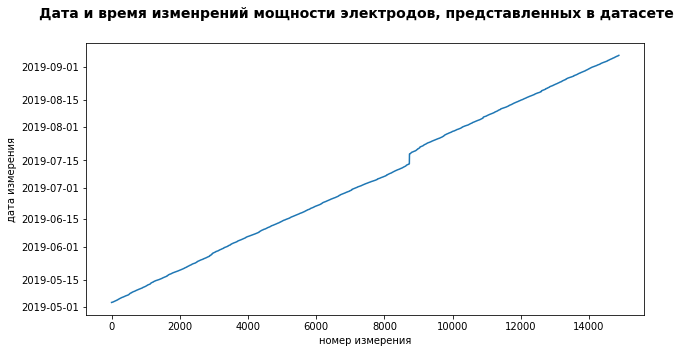

In [8]:
fig,ax = plt.subplots(figsize = (20,10))
data_arc_new['Начало нагрева дугой'].astype(datetime64).plot(figsize = (10,5));
ax.set(xlabel = 'номер измерения', ylabel = 'дата измерения');
fig.suptitle('Дата и время изменрений мощности электродов, представленных в датасете', fontsize=14, fontweight='bold');

Представленные данные содержат информацию за 2019 год с мая по сентябрь. Есть провал в значениях в районе 15 июня

Посмотрим какие значения принимает параметр 'key'

In [9]:
print(len(data_arc_new['key'].unique()))
print(data_arc_new['key'].unique())

3214
[   1    2    3 ... 3239 3240 3241]


Значения параметра key в таблице повторяются для нескольких строк, вероятно эти значения относятся к одной партии. Присутствуют не все номера партий в ряду от 1 до 3241. Всего в таблице содержится информация о 3214 партиях.

Теперь оценим вариативность значений Активной и Реактивной мощности

In [10]:
pw = data_arc_new[['Активная мощность','Реактивная мощность']]

In [11]:
pw.head(10)

Активная мощность  Реактивная мощность
0           0.305130             0.211253
1           0.765658             0.477438
2           0.580313             0.430460
3           0.518496             0.379979
4           0.867133             0.643691
5           0.381124             0.220351
6           0.261665             0.205527
7           0.710297             0.484962
8           0.786322             0.542517
9           1.101678             0.820856

Странное отрицательное значение Реактивной мощности -715


In [12]:
pw.describe()

Активная мощность  Реактивная мощность
count       14876.000000         14876.000000
mean            0.662752             0.438986
std             0.258885             5.873485
min             0.223120          -715.479924
25%             0.467115             0.337175
50%             0.599587             0.441639
75%             0.830070             0.608201
max             1.463773             1.270284

Так и есть значение Реактивной мощности -715,479924 является выбросом. Построим график без него.

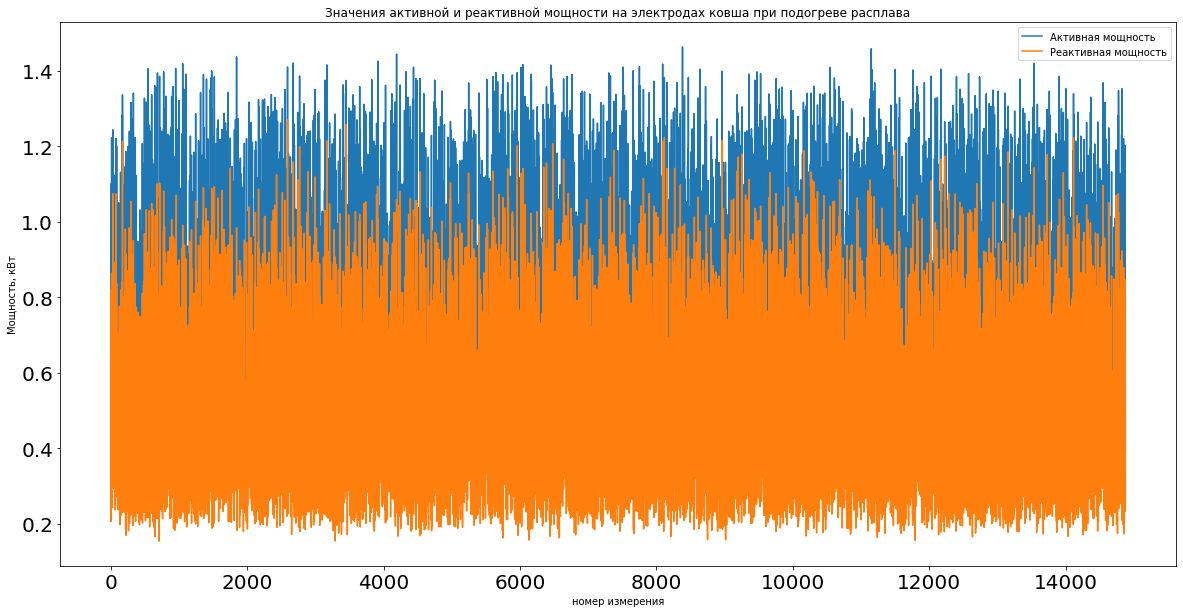

In [13]:
pw.loc[pw['Реактивная мощность']>-715].plot(figsize =(20,10),xlabel = 'номер измерения', ylabel = 'Мощность, кВт',
                                           title = 'Значения активной и реактивной мощности на электродах ковша при подогреве расплава',
                                            fontsize=20);

Активная мощность тратится на совершение работы(нагрев стали), а реактивная это потери.По графику видно, что значение активной мощности выше реактивной и для различных измерений меняется соотношение между ними. Средние значения активной и реактивной мощности не меняются со временем, значит этот показатель процесса относительно стабилен от партии к партии.

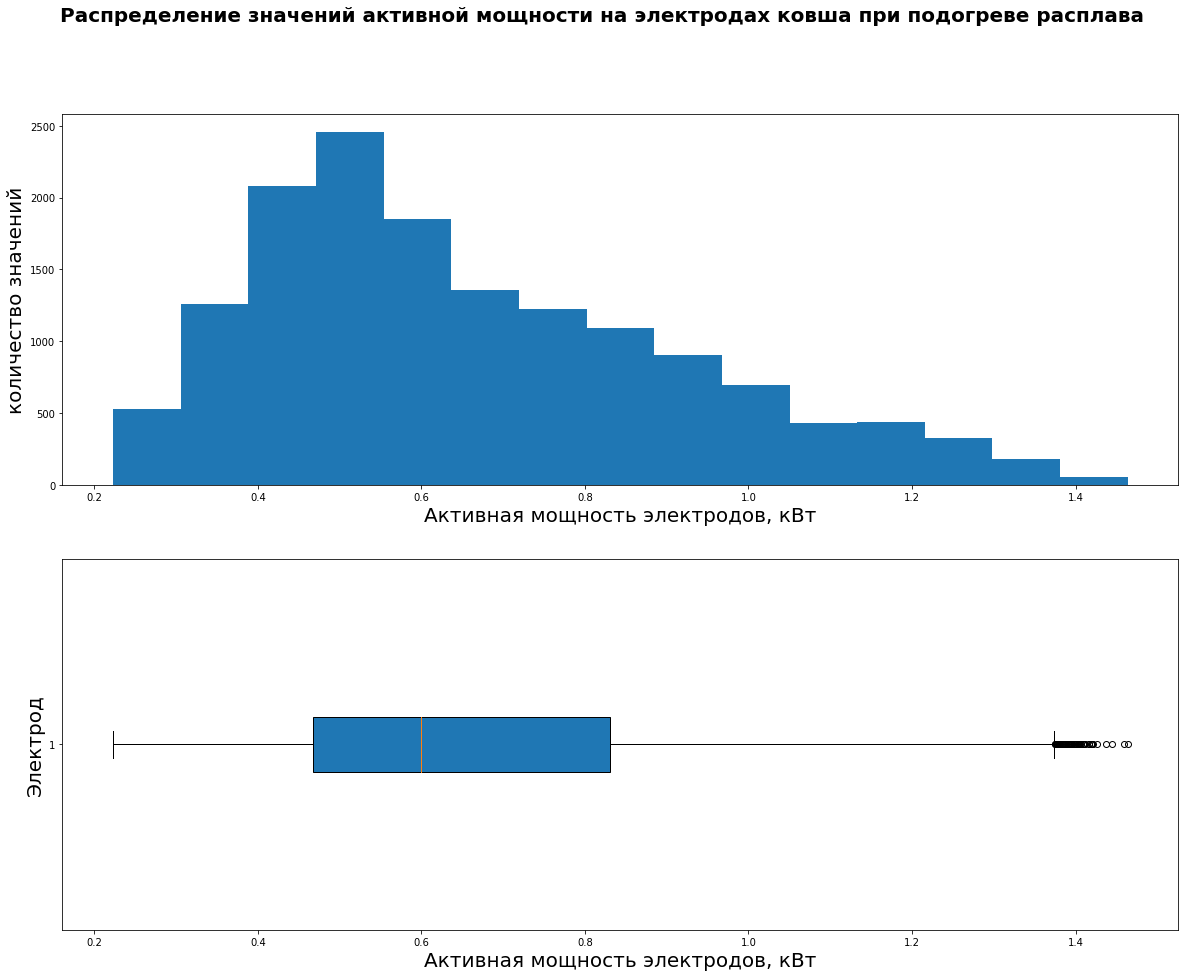

In [16]:
plt.rc('axes', labelsize=20);
plt.rc('axes', titlesize=20);
pw_1 = pw.loc[pw['Реактивная мощность']>-715]
fig = plt.figure(figsize = (20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(pw_1['Активная мощность'],bins = 15)
ax2.boxplot(pw_1['Активная мощность'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений активной мощности на электродах ковша при подогреве расплава', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Активная мощность электродов, кВт');
ax2.set(ylabel = 'Электрод', xlabel = 'Активная мощность электродов, кВт');
plt.show();

Основные значения активной мощности для датасета расположены между значениями 0,22кВт и 1,38 кВт. Распределение скошено влево. Есть выбросы , это значения мощности выше 1,38 кВт. Медианное значение равно 0,59кВт.

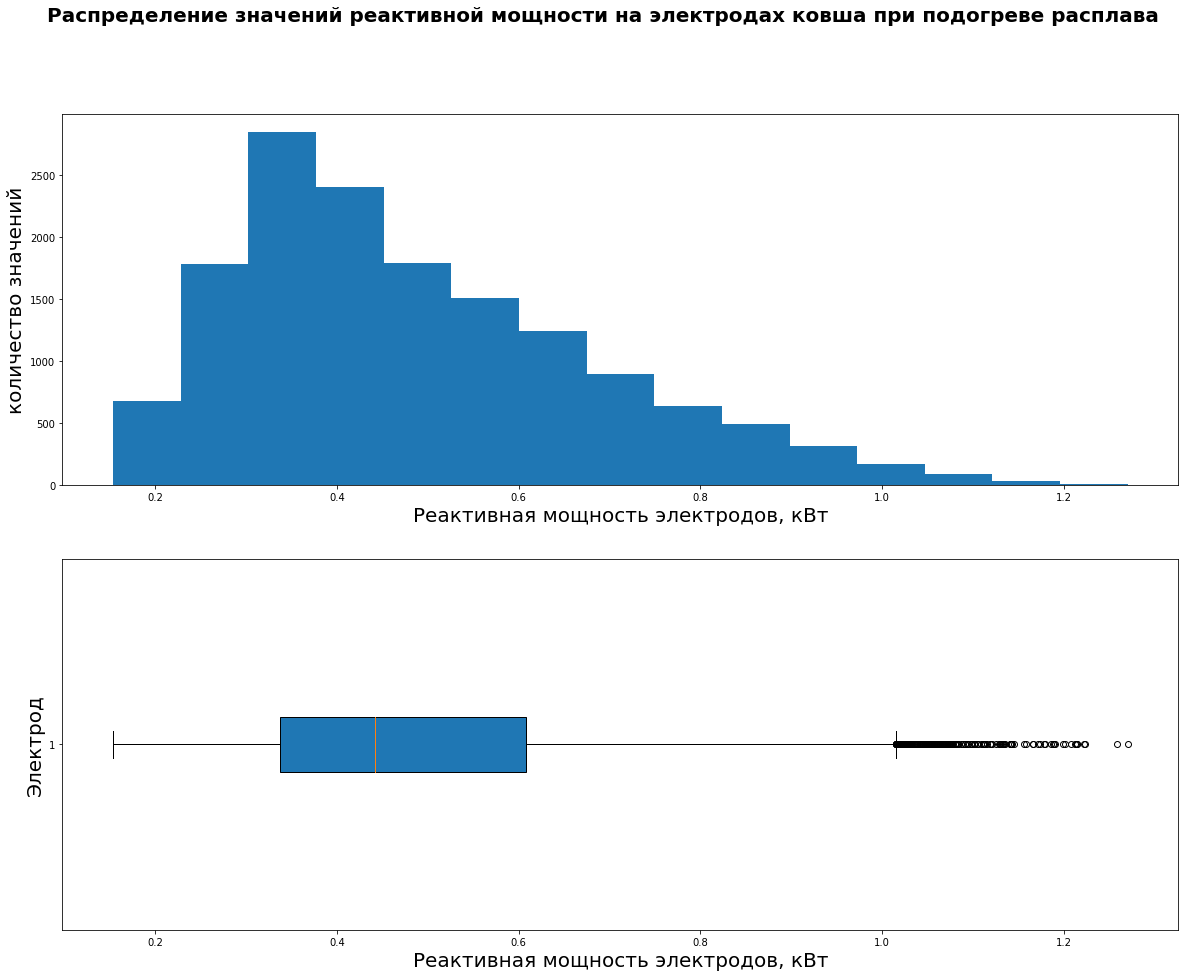

In [17]:
plt.rc('axes', labelsize=20);
plt.rc('axes', titlesize=20);
fig = plt.figure(figsize = (20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(pw_1['Реактивная мощность'],bins = 15)
ax2.boxplot(pw_1['Реактивная мощность'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений реактивной мощности на электродах ковша при подогреве расплава', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Реактивная мощность электродов, кВт');
ax2.set(ylabel = 'Электрод', xlabel = 'Реактивная мощность электродов, кВт');
plt.show();

In [18]:
pw_1['Реактивная мощность'].describe()

count    14875.000000
mean         0.487115
std          0.197612
min          0.153777
25%          0.337190
50%          0.441665
75%          0.608223
max          1.270284
Name: Реактивная мощность, dtype: float64

Основные значения реактивной мощности для датасета расположены между значениями 0,15кВт и 1,0 кВт. Распределение скошено влево как и в случае с активной мощностью. Есть выбросы , это значения мощности выше 1,0 кВт. Медианное значение равно 0,44кВт.

Для оптимизации потерь можно попытаться понять за счет чего можно уменьшить реактивную мощность, в нашей задаче мы будем ориентироваться на суммарные значения, так как энергопотребление будет складываться из активной и реактивной мощности.Есть способы рекуперации реактивной мощности, что можно отметить для заказчика в отчете. Можно еще улучшить интерпретируемость значений мощности, выразив её через энергопотребление, для чего надо умножить суммарную мощность электрода на время его работы.Единицы измерения: кВт*час.

### Данные о подаче сыпучих материалов (объём), котрые храняться в датасете data_bulk_new.csv

In [19]:
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')

In [20]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В таблице содержится информация о загрузке сыпучих добавок, данные сгруппированы по параметру "key", по партии.Размер датасета 3129 х 16, имеется параметр Bulk с порядковыми номерами от 1 до 15, вероятно так обозначены различные типы сыпучих добавок.Много пропущенных значений, это связано с особенностью технологического процесса: так добавка под номером 8 применяется всего 1 раз, а добавка с номером 14 целых 2806 раз. Тип данных соответствует значениям переменных. Названия столбцов не приведено к змеиному регистру.

In [21]:
data_bulk_new.head(6)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0

В датасете по навескам сыпучих добавок все номера партии уникальны и не повторяются.

In [22]:
print(data_bulk_new['key'].unique())
print(len(data_bulk_new['key'].unique()))

[   1    2    3 ... 3239 3240 3241]
3129


В этом датасете уникальных значений номеров партий больше чем в предыдущем, значит здесь есть номера партий, которых нет в датасете по электродам.

In [23]:
data_bulk_new.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [24]:
data_bulk_new_1 = data_bulk_new.drop(columns=['key'])


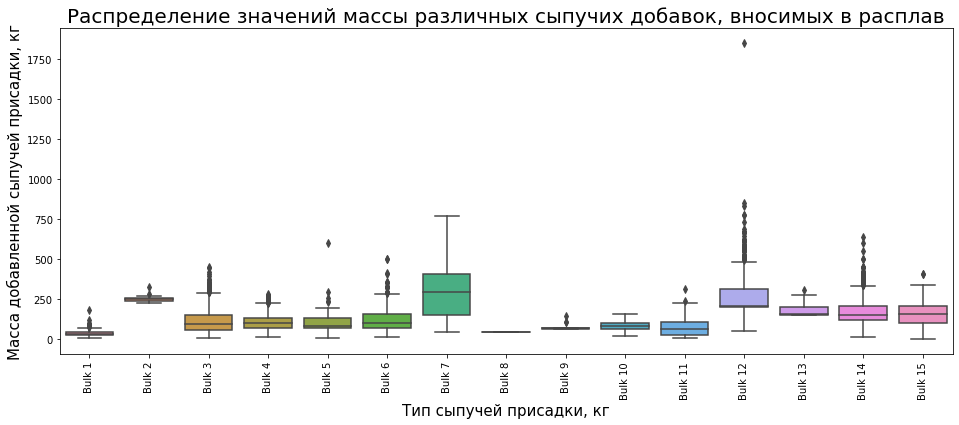

In [30]:
plt.figure(figsize=(16, 6)) 
bp = sns.boxplot(data = data_bulk_new_1)
bp.set_title ('Распределение значений массы различных сыпучих добавок, вносимых в расплав');
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);
bp.set_ylabel('Масса добавленной сыпучей присадки, кг',fontsize=15);
bp.set_xlabel('Тип сыпучей присадки, кг',fontsize=15);
plt.show();

На распределении видны выбросы(аномалии), что некоторые добавки имеют достаточно сильный разброс по весу, напромер 12, можно выявить "редкие виды", например добавка с номером 8(применялась всего 1 раз),неравномерность распределения вокруг среднего значения. Можно будет смело удалить плавку, в которой масса добавки 15 приняла значения более 1750 кг.

### Таблица с информацией о времени и дате подачи сыпучих реагентов data_bulk_time_new.csv

In [31]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [32]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Количество строк соответствует таблице data_bulk_time_new, что логично, так как эта таблица является ее дополнением. Похоже, что ячейки с пропущенными значениями связаны с технологическим процессом, количество пропущенных значений в этих 2-х таблицах идентичны по соответствующим признакам. Дата и время, возможно, стоит перевести в формат datetime64.



In [33]:
data_bulk_time_new.head(5)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

In [34]:
data_bulk_time_new.tail(5)

key Bulk 1 Bulk 2               Bulk 3 Bulk 4 Bulk 5  \
3124  3237    NaN    NaN  2019-09-06 11:54:15    NaN    NaN   
3125  3238    NaN    NaN  2019-09-06 12:26:52    NaN    NaN   
3126  3239    NaN    NaN                  NaN    NaN    NaN   
3127  3240    NaN    NaN                  NaN    NaN    NaN   
3128  3241    NaN    NaN                  NaN    NaN    NaN   

                   Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
3124                  NaN    NaN    NaN    NaN     NaN     NaN   
3125                  NaN    NaN    NaN    NaN     NaN     NaN   
3126  2019-09-06 15:06:00    NaN    NaN    NaN     NaN     NaN   
3127  2019-09-06 16:24:28    NaN    NaN    NaN     NaN     NaN   
3128                  NaN    NaN    NaN    NaN     NaN     NaN   

                  Bulk 12 Bulk 13              Bulk 14              Bulk 15  
3124  2019-09-06 11:49:45     NaN  2019-09-06 11:45:22  2019-09-06 11:40:06  
3125  2019-09-06 12:18:35     NaN  2019-09-06 12:31:49  2019-09-06 12:26:52  
3126  2019-09-06 15:01:44     NaN  2019-09-06 14:58:15  2019-09-06 14:48:06  
3127                  NaN     NaN  2019-09-06 16:07:29  2019-09-06 16:01:34  
3128                  NaN     NaN  2019-09-06 17:26:33  2019-09-06 17:23:15

Данные также сгруппированы по уникальным значениям параметра "key", номеру партии

### Данные о продувке сплава газом

В ходе технологического процесса происходит периодическая продувка зоны плавки энертным газом. Пузырьки газа, всплывающие при продувке через весь слой металла, оказывают на него рафинирующее действие. Вследствие увеличения интенсивности массопереноса в ковше происходит выравнивание состава и температуры в объеме металла. Интенсивное перемешивание ускоряет доставку неметаллических включений к поверхности металл-шлак и удаление их из стали.

In [35]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Таблица содержит 3239 значений объёмов газа, пропускаемого через зону плавки. Пропущенных значений нет. Названия столбцов не приведены к змеиному регистру и содержат латиницу и кириллицу вперемешку. Похоже, что в технологическом процессе продувка осуществляется всего 1 раз за все время обработки партии сплава.

In [36]:
print(data_gas_new['key'].unique())
print(len(data_gas_new['key'].unique()))

[   1    2    3 ... 3239 3240 3241]
3239


В данной таблице количество уникальных значений и сами значения параметра "key" не полностью совпадают с данными таблицы по загрузке сыпучих реагентов, значит и здесь присутствуют не все номера партий.

In [37]:
data_gas_new.head(5)

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

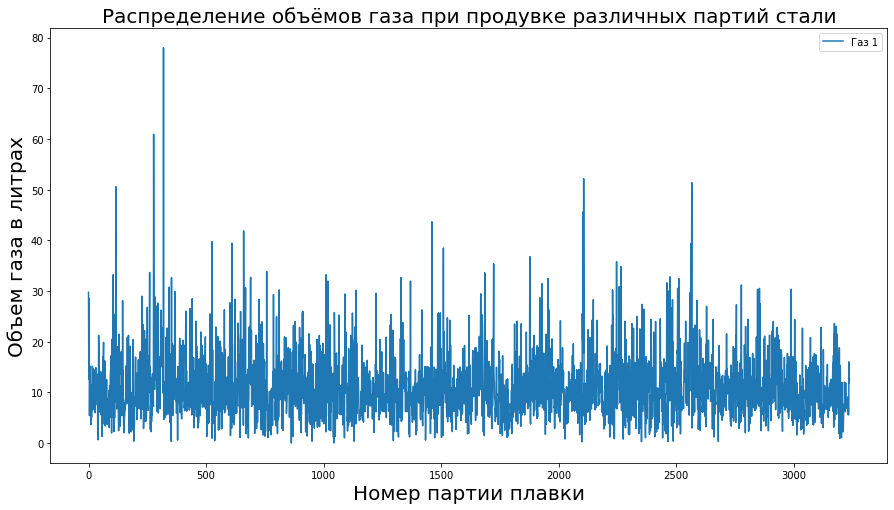

In [38]:
data_gas_new.plot(y= 'Газ 1', figsize = (15,8), title = "Распределение объёмов газа при продувке различных партий стали",
                  ylabel = "Объем газа в литрах", xlabel = "Номер партии плавки");

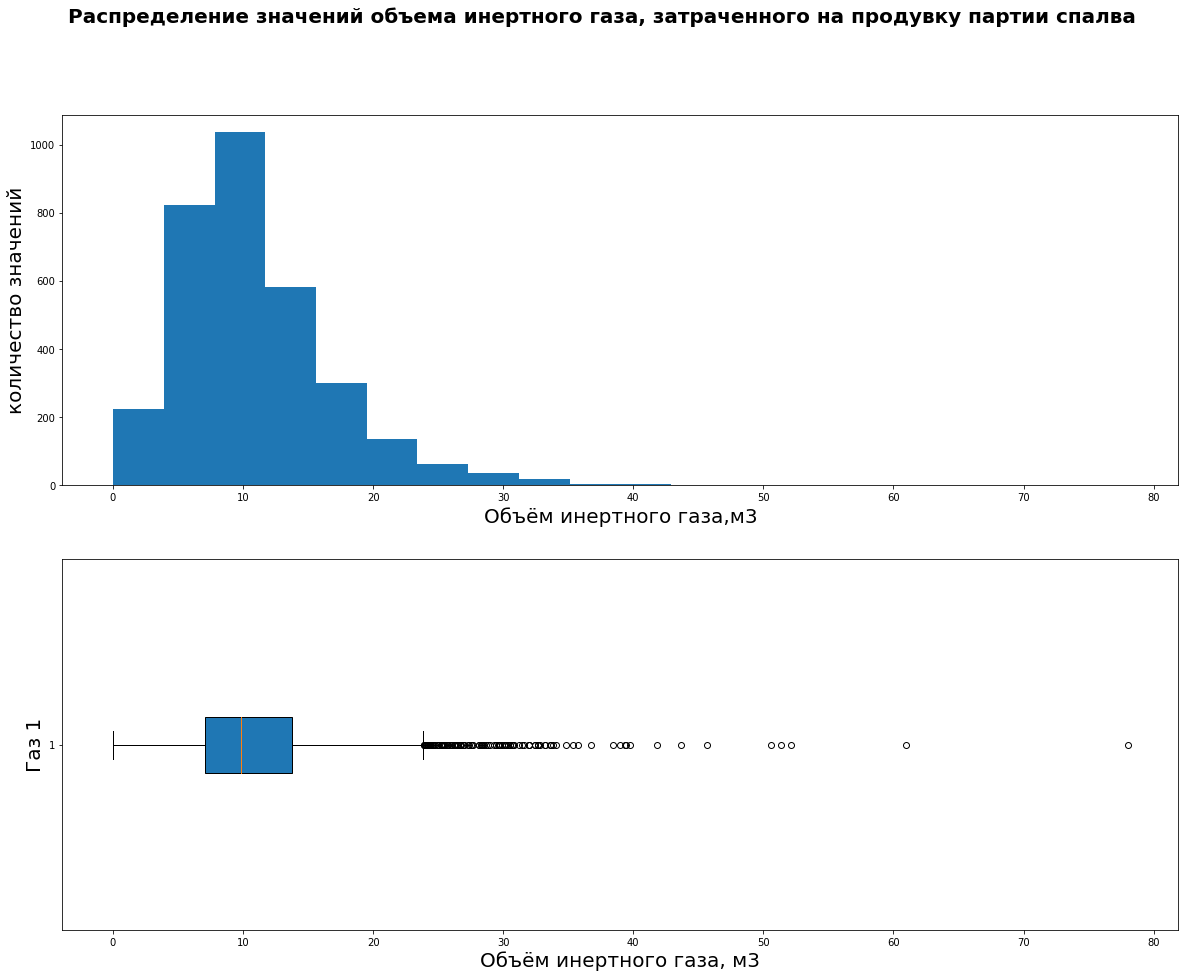

In [40]:
data_gas_new_1 = data_gas_new.drop(columns=['key'])
fig = plt.figure(figsize = (20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(data_gas_new_1,bins = 20)
ax2.boxplot(data_gas_new_1,vert =False,patch_artist=True)
fig.suptitle('Распределение значений объема инертного газа, затраченного на продувку партии спалва', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Объём инертного газа,м3');
ax2.set(ylabel = 'Газ 1', xlabel = 'Объём инертного газа, м3');

Есть скачки объёма до 80 л, узнать у заказчика норма ли это? Данные содержат много шума.

In [41]:
data_gas_new['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

Основной диапазон значений объемов инертного газа расположился между 7 и 13 литрами. Есть значения на порядок больше медианного до 78 литров (и много значений находится за границей "усов" ящика) и совсем маленькие значения (0,0083 литра), которые можно считать за отсутствие продувки. Но низкие значения лежат ниже первого квартиля, т.е. это нормальные значения, а вот большие значения надо проверить.

### Результаты измерения температуры

Датафрейм содержит историю измерения температуры в ходе процесса обработки стали для каждой партии (в ходе процесса измерение температуры производится несколько раз для контроля за поддержанием режимов обработки).

Этот датасет содержит целевое значение, которое мы должны предсказать созданной моделью, а именно, температуру готового сплава. Начальная температура расплава можно использовать в качестве обучающего признака.

In [42]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Таблица содержит 14665 значений температуры, которая фиксировалась на определенный момент времени для конкретной плавки (параметр 'key'). Но не в каждый момент, в измерения присутствуют пропуски , необходимо разобраться в причине отсутствия значений и принять решение об их удалении или заполнении.

In [43]:
data_temp_new.head(5)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

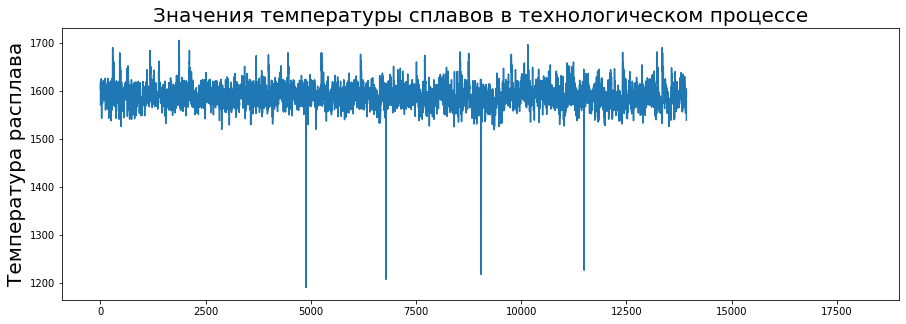

In [44]:
data_temp_new['Температура'].plot(figsize = (15,5), title = "Значения температуры сплавов в технологическом процессе",
                  ylabel = "Температура расплава");

Есть низкие значения температур, необходимо проверить их адекватность процессу. Возможно, температура падала по причине технических сбоев.Если такое возможно в технологическом процессе, то, может это как-то получится учесть при моделировании, а возможно стоит удалить.



In [45]:
data_temp_new['Температура'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

Разброс значений температуры в датасете лежит, в основном, между 1580С и 1599С, так как на этом этапе технологического процесса требуется поддержание температуры в ковше в процессе легирования и десульфуризации сплава. Но есть и резко отличающиеся значения температуры, выходящие за границы нормального распределния(например ниже 1200С). Возможно это сбой при измерении или сбой в работе электродов и тогда эти значения переходят в разряд аномальных. Хотя возможно был сплав с более низкой температурой плавления.Надо смотреть другие температуры в этих партиях.

### данные о проволочных материалах (объём)

Проволока это также форма лигирующей добавки. Датафрейм содержит информацию об объеме проволоки, затраченной на партию стали.

In [46]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Датафрейм содержит 3081 значение объема проволоки,подаваемого в зону расплава на различных этапах десульфуризации. Данные сгруппированы по уникальным значениям параметра "key". В таблице много пропущенных значений, которые, как и в описанных выше датафреймах, обусловлены технологическим процессом. Отмечу, что значения параметра "key" также не идентичны значениям в рассмотренных выше таблицах. Параметр Wire имеет от 1 до 9, необходимо понять, что они обозначают.



In [47]:
data_wire_new.head(5)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [48]:
data_wire_new.describe()

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

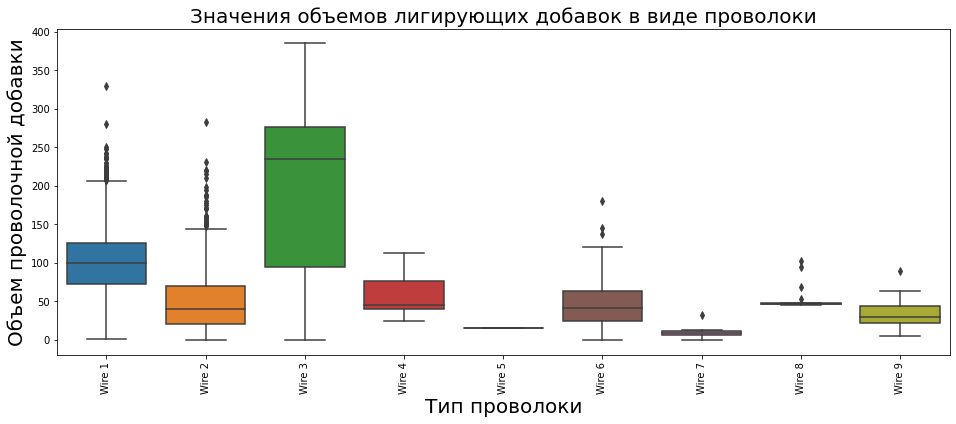

In [49]:
data_wire_new_1 = data_wire_new.drop(columns=['key'])
plt.figure(figsize=(16, 6)) 
bp = sns.boxplot(data = data_wire_new_1)

bp.set_title ('Значения объемов лигирующих добавок в виде проволоки');
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);
bp.set_ylabel('Объем проволочной добавки');
bp.set_xlabel('Тип проволоки');

Видно, что есть разброс в значениях между параметрами даже на порядок. Норма это или нет, вопрос технологического процесса. Возможно была сталь экзотического состава и проволоки понадобилось существенно меньше или больше. Различные виды проволочных лигирующих добавок расходуются по-разному, самая вариативная по объему использования проволока 3, но все значения объемов для нее попадают в нормальное распределение. Самая экзотическая: проволока 1, использовалась 1 раз (почти как сыпучая добавка 8), может варили что-то уникальное. Значения для типов 1 и 2 имеют много выбросов за пределом нормального распределения.

### данные о проволочных материалах (время)

Датафрейм содержит информацию о времени и дате введения проволочной лигирующей добавки каждого типа и является дополнением таблицы data_wire_new.

Таблица связана с data_wire_new, дополняет её информацией о дате и времени ввода проволоки в зону плавки. Тип данных "object" необходимо привести к "datetime64", если эти данные пригодятся для обучения модели.

In [50]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Размер датафрейма 3081 строка и 2 столбца, содержит информацию о времени введения проволочной лигирующей добавки в зону плавки, информация представлена для 9 различных типов добавок (Wire). Данные содержат большое количество пропусков, вероятно, они связаны с использованием в различных партиях стали разных добавок, пропуски можно будет заметь нулями.

In [51]:
data_wire_time_new.head(6)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN

In [52]:
data_wire_time_new.tail(6)

key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7  \
3075  3236  2019-09-06 10:57:48    NaN    NaN    NaN    NaN    NaN    NaN   
3076  3237  2019-09-06 11:33:38    NaN    NaN    NaN    NaN    NaN    NaN   
3077  3238  2019-09-06 12:18:35    NaN    NaN    NaN    NaN    NaN    NaN   
3078  3239  2019-09-06 14:36:11    NaN    NaN    NaN    NaN    NaN    NaN   
3079  3240  2019-09-06 15:33:55    NaN    NaN    NaN    NaN    NaN    NaN   
3080  3241  2019-09-06 17:10:06    NaN    NaN    NaN    NaN    NaN    NaN   

     Wire 8 Wire 9  
3075    NaN    NaN  
3076    NaN    NaN  
3077    NaN    NaN  
3078    NaN    NaN  
3079    NaN    NaN  
3080    NaN    NaN

In [53]:
print(len(data_wire_time_new['key'].unique()))
print(data_wire_time_new['key'].unique())

3081
[   1    2    3 ... 3239 3240 3241]


В этом датафрейме также номера партий не полность совпадают с номерами в других таблицах.

##  Подготовка исходных данных

Для начала посмотрим, что происходит с одной из партий стали в технологическом процессе:

In [54]:
data_arc_new_exp = data_arc_new.query('key == 1')
display(data_arc_new_exp)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

нагрев включался 5 раз с 11:02:14 до 11:28:37

In [55]:
data_bulk_new_exp = data_bulk_new.query('key ==1')
display(data_bulk_new_exp)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0

In [56]:
data_bulk_time_new_exp = data_bulk_time_new.query('key ==1')
display(data_bulk_time_new_exp)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   

               Bulk 15  
0  2019-05-03 11:10:43

в 11:10:43 - внесена добавка Bulk 15 (в 11:11:44 включился нагрев в 3 раз за цикл плавки).  
в 11:14:50 - внесена добавка Bulk 14 (в 11:14:36 выключился третий нагрев).  
в 11:24:31 - внесена добавка Bulk 12(в 11:26:09 нагрев включился).  
в 11:28:48 - внесена сыпучая добавка Bulk 4( в 11:28:37 нагрев прекратился, а добавка была внесена позже и больше циклов нагрева не было).  
Похоже использовать время для восстановления хронологии не получится, есть рассинхронизация процессов в таблицах.

In [57]:
data_wire_new_exp = data_wire_new.query('key ==1')
display(data_wire_new_exp)

key     Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN

In [58]:
data_wire_time_new_exp = data_wire_time_new.query('key ==1')
display(data_wire_time_new_exp)

key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8  \
0    1  2019-05-03 11:06:19    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

  Wire 9  
0    NaN

1 раз в 11:06:19 была введена проволочная добавка типа Wire 1

In [59]:
data_gas_new_exp = data_gas_new.query('key ==1')
display(data_gas_new_exp)

key      Газ 1
0    1  29.749986

Так же имела место быть однократная продувка системы инертным газом или суммарный объем газа,пропущенного через систему за все время обработки стали, партии 1.

In [60]:
data_temp_new_exp = data_temp_new.query('key ==1')
display(data_temp_new_exp)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0

Измерения температыры производились 6 раз, привязать измерения к каким-либо событиям трудно,в виду рассинхронизации данных.

### Подготовка данных по электродам

Приступим к подготовке данных. Начнем с таблицы,содержащей информацию по электродам:

Добавим столбец, в котором разместим информацию о времени, в течение которого электрод подогревал сплав, время переведём в часы:

In [61]:
data_arc_new['Время работы электрода'] = ((data_arc_new['Конец нагрева дугой'].
                                          astype(datetime64) - data_arc_new['Начало нагрева дугой'].
                                          astype(datetime64)).dt.seconds)/3600

In [62]:
data_arc_new.head(5)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  Время работы электрода  
0             0.211253                0.063333  
1             0.477438                0.051389  
2             0.430460                0.047778  
3             0.379979                0.101389  
4             0.643691                0.041111

In [63]:
data_arc_new.duplicated().sum()

0

Полных дубликатов нет.

In [64]:
data_arc_new.describe()

key  Активная мощность  Реактивная мощность  \
count  14876.000000       14876.000000         14876.000000   
mean    1615.220422           0.662752             0.438986   
std      934.571502           0.258885             5.873485   
min        1.000000           0.223120          -715.479924   
25%      806.000000           0.467115             0.337175   
50%     1617.000000           0.599587             0.441639   
75%     2429.000000           0.830070             0.608201   
max     3241.000000           1.463773             1.270284   

       Время работы электрода  
count            14876.000000  
mean                 0.047686  
std                  0.027274  
min                  0.003056  
25%                  0.029722  
50%                  0.040833  
75%                  0.059444  
max                  0.251944

Есть выброс в значениях реактивной мощности в -715,48 кВт, надо будет удалить всю партию, к которой относится аномальное значение.

In [65]:
df_arc = data_arc_new.drop(columns = ['Начало нагрева дугой','Конец нагрева дугой'], axis = 1)
df_arc.head(6)

key  Активная мощность  Реактивная мощность  Время работы электрода
0    1           0.305130             0.211253                0.063333
1    1           0.765658             0.477438                0.051389
2    1           0.580313             0.430460                0.047778
3    1           0.518496             0.379979                0.101389
4    1           0.867133             0.643691                0.041111
5    2           0.381124             0.220351                0.038056

In [66]:
df_arc = df_arc.groupby('key').sum()
display(df_arc.head(4))
print(df_arc.info())

Активная мощность  Реактивная мощность  Время работы электрода
key                                                                
1             3.036730             2.142821                0.305000
2             2.139408             1.453357                0.225278
3             4.063641             2.937457                0.181944
4             2.706489             2.056992                0.205833

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Активная мощность       3214 non-null   float64
 1   Реактивная мощность     3214 non-null   float64
 2   Время работы электрода  3214 non-null   float64
dtypes: float64(3)
memory usage: 100.4 KB
None


Теперь переведем эти значения в кВт*ч

In [67]:
df_arc['Энергопотребление'] = (df_arc['Активная мощность'] + df_arc['Реактивная мощность'])*df_arc['Время работы электрода']
df_arc.head(4)

Активная мощность  Реактивная мощность  Время работы электрода  \
key                                                                   
1             3.036730             2.142821                0.305000   
2             2.139408             1.453357                0.225278   
3             4.063641             2.937457                0.181944   
4             2.706489             2.056992                0.205833   

     Энергопотребление  
key                     
1             1.579763  
2             0.809370  
3             1.273811  
4             0.980483

In [68]:
print(len(data_arc_new['key'].unique()))

3214


все отлично, партии не потеряли, пропусков там не было

In [69]:
df_arc.describe()

Активная мощность  Реактивная мощность  Время работы электрода  \
count        3214.000000          3214.000000             3214.000000   
mean            3.067549             2.031849                0.220716   
std             1.208554            12.665145                0.092347   
min             0.267676          -713.966032                0.015833   
25%             2.236770             1.630658                0.158611   
50%             2.984581             2.176833                0.213889   
75%             3.775472             2.788330                0.273056   
max            12.375636             8.949049                1.163611   

       Энергопотребление  
count        3214.000000  
mean            1.283001  
std             1.884107  
min           -85.557100  
25%             0.644629  
50%             1.099374  
75%             1.685417  
max            24.813640

In [70]:
df_arc = df_arc.loc[df_arc['Реактивная мощность']>-713]

удалим аномальное значение реактивной мощности -713,96 кВт вместе с информацией о партии.

In [71]:
df_arc.describe()

Активная мощность  Реактивная мощность  Время работы электрода  \
count        3213.000000          3213.000000             3213.000000   
mean            3.067683             2.254693                0.220748   
std             1.208719             0.894787                0.092344   
min             0.267676             0.196228                0.015833   
25%             2.236693             1.631855                0.158611   
50%             2.984607             2.177210                0.213889   
75%             3.775574             2.788381                0.273056   
max            12.375636             8.949049                1.163611   

       Энергопотребление  
count        3213.000000  
mean            1.310028  
std             1.096545  
min             0.013046  
25%             0.645157  
50%             1.099595  
75%             1.685504  
max            24.813640

In [72]:
df_arc_fin = df_arc.drop(columns = ['Активная мощность','Реактивная мощность'], axis = 1)
df_arc_fin.head()

Время работы электрода  Энергопотребление
key                                           
1                  0.305000           1.579763
2                  0.225278           0.809370
3                  0.181944           1.273811
4                  0.205833           0.980483
5                  0.241389           0.951299

In [73]:
df_arc_fin = df_arc_fin.reset_index()

In [74]:
print(df_arc_fin.info(5))
df_arc_fin.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     3213 non-null   int64  
 1   Время работы электрода  3213 non-null   float64
 2   Энергопотребление       3213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.4 KB
None


key  Время работы электрода  Энергопотребление
0    1                0.305000           1.579763
1    2                0.225278           0.809370
2    3                0.181944           1.273811
3    4                0.205833           0.980483
4    5                0.241389           0.951299

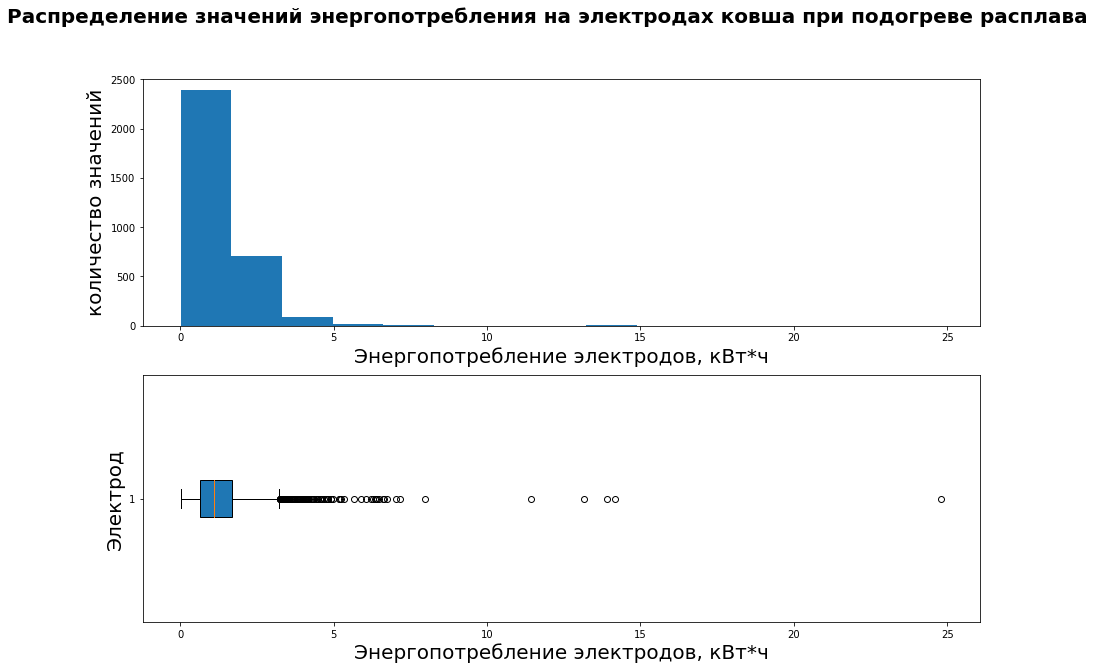

In [75]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df_arc_fin['Энергопотребление'],bins = 15)
ax2.boxplot(df_arc_fin['Энергопотребление'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений энергопотребления на электродах ковша при подогреве расплава', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Энергопотребление электродов, кВт*ч');
ax2.set(ylabel = 'Электрод', xlabel = 'Энергопотребление электродов, кВт*ч');


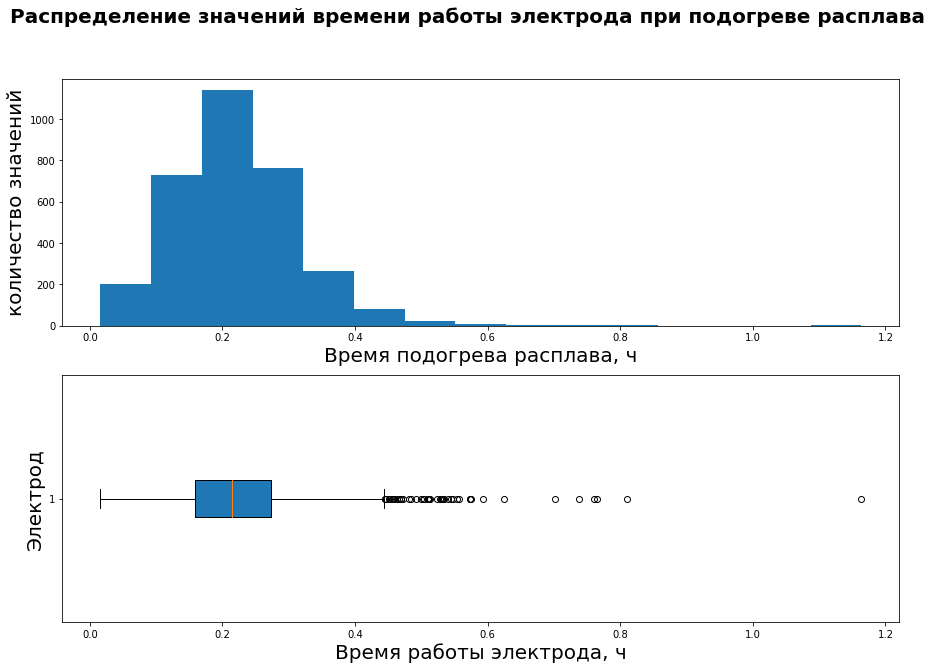

In [76]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df_arc_fin['Время работы электрода'],bins = 15)
ax2.boxplot(df_arc_fin['Время работы электрода'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений времени работы электрода при подогреве расплава', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Время подогрева расплава, ч');
ax2.set(ylabel = 'Электрод', xlabel = 'Время работы электрода, ч');


In [77]:
df_arc_fin.head()

key  Время работы электрода  Энергопотребление
0    1                0.305000           1.579763
1    2                0.225278           0.809370
2    3                0.181944           1.273811
3    4                0.205833           0.980483
4    5                0.241389           0.951299

In [78]:
df_arc_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     3213 non-null   int64  
 1   Время работы электрода  3213 non-null   float64
 2   Энергопотребление       3213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 75.4 KB


После удаления выбросов датасет сократился c 3214 партий до 3213, ушла 1 партия!

### Данные о подаче сыпучих материалов (дм3)

In [79]:
display(data_bulk_new.head())
display(data_bulk_new.describe())
data_bulk_new.info()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [80]:
data_bulk_new.duplicated().sum()

0

Полных дубликатов нет.

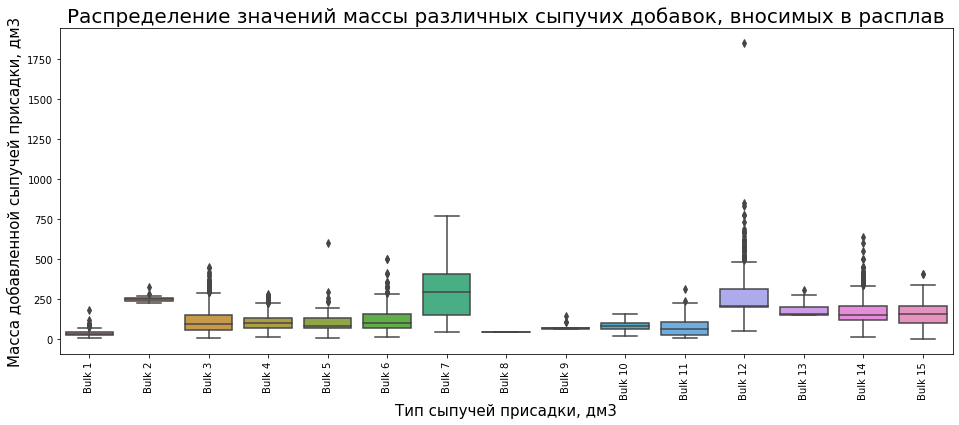

In [83]:
data_bulk_new_1 = data_bulk_new.drop(columns=['key'])
plt.figure(figsize=(16, 6)) 
bp = sns.boxplot(data = data_bulk_new_1)
bp.set_title ('Распределение значений массы различных сыпучих добавок, вносимых в расплав');
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);
bp.set_ylabel('Масса добавленной сыпучей присадки, дм3',fontsize =15);
bp.set_xlabel('Тип сыпучей присадки, дм3',fontsize =15);

Также в таблице множество пропущенных значение, которые говорят о том, что текущая сыпучая добавка не применялась для изготовления данной партии стали, поэтому пропуски можно заменить нулями.

In [84]:
data_bulk_new_fin= data_bulk_new.fillna(0)

In [85]:
data_bulk_new_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [86]:
data_bulk_new_fin.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0

Все преобразования выполнены правильно.

### Таблица с информацией о времени и дате подачи сыпучих реагентов 

In [87]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [88]:
data_bulk_time_new.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Так как данные рассогласованы по времени, информация в данном датасете не несет ценности.

### Данные о продувке сплава газом

In [89]:
display(data_gas_new.head())
data_gas_new.info()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [90]:
data_gas_new.duplicated().sum()

0

Полных дубликатов нет.

In [91]:
data_gas_new['Газ 1'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

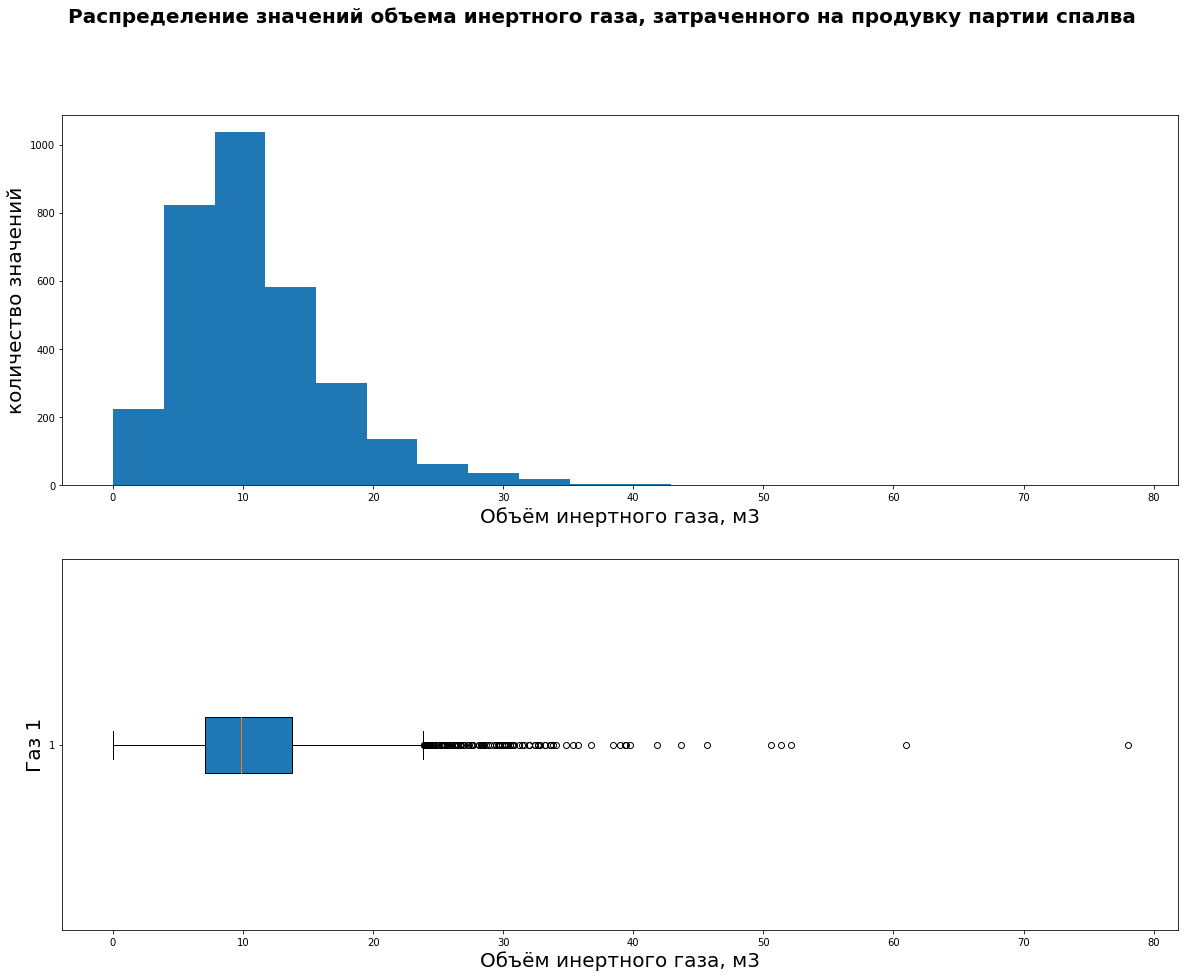

In [92]:
data_gas_new_1 = data_gas_new.drop(columns=['key'])
fig = plt.figure(figsize = (20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(data_gas_new_1,bins = 20)
ax2.boxplot(data_gas_new_1,vert =False,patch_artist=True)
fig.suptitle('Распределение значений объема инертного газа, затраченного на продувку партии спалва', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Объём инертного газа, м3');
ax2.set(ylabel = 'Газ 1', xlabel = 'Объём инертного газа, м3');
plt.show()

Экстремально высоких значений не много, решим вопрос их удаления после объединения с другими признаками.

### Результаты измерения температуры

Датафрейм содержит целевой признак: конечную температуру расплава,которую и будет рассчитывать наша модель. Начальная температура сплава это один из признаков для обучения модели. Можно выделить еще 1 признак, это время между первым измерением и последним, он поможет оценить время технологической обработки каждой марки стали. Промежуточные значения можно удалить.

In [93]:
display(data_temp_new.head(10))
data_temp_new.info()


key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0
7    2  2019-05-03 11:38:40       1577.0
8    2  2019-05-03 11:46:09       1589.0
9    2  2019-05-03 11:49:38       1604.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [94]:
data_temp_new['Время замера'] = data_temp_new['Время замера'].astype(datetime64)

In [95]:
data_temp_new.duplicated().sum()

0

Полных дубликатов нет.

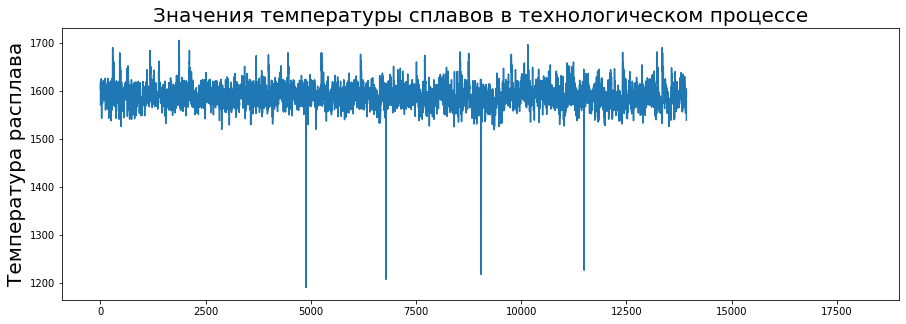

In [96]:
data_temp_new['Температура'].plot(figsize = (15,5), title = "Значения температуры сплавов в технологическом процессе",
                  ylabel = "Температура расплава");

Согласно справочным данным нижняя граница температуры плавления стали не может быть ниже 1300 С,это, однозначно, аномалия.

Выясним номера партий стали, содержащих аномальные значения:

In [97]:
data_temp_new_anomal = data_temp_new.loc[data_temp_new['Температура']<=1300]
display(data_temp_new_anomal)

key        Время замера  Температура
4883    867 2019-06-06 08:03:39       1191.0
6784   1214 2019-06-18 08:01:03       1208.0
9050   1619 2019-07-03 02:34:41       1218.0
11495  2052 2019-07-25 08:49:15       1227.0
14283  2561 2019-08-12 18:49:29       1204.0

Отфильтруем лишнее:

In [98]:
data_temp_new_1 = data_temp_new.loc[~data_temp_new['key'].isin([867,1214,1619,2052,2561])]

In [99]:
data_temp_new_1.query('key==867')

Empty DataFrame
Columns: [key, Время замера, Температура]
Index: []

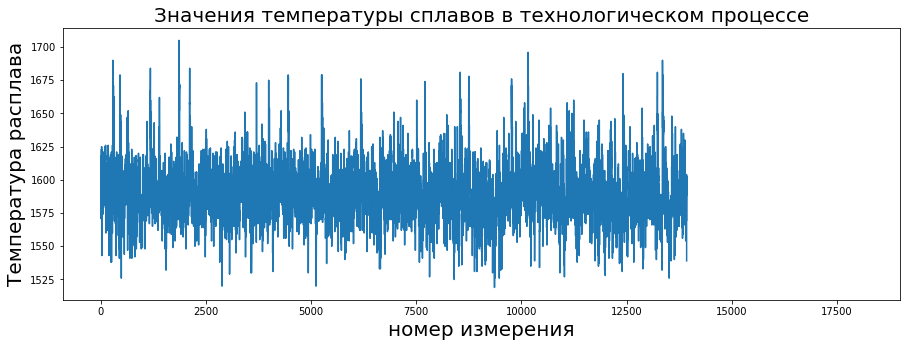

In [100]:
data_temp_new_1['Температура'].plot(figsize = (15,5), title = "Значения температуры сплавов в технологическом процессе",
                  ylabel = "Температура расплава",xlabel = 'номер измерения');

Теперь больше похоже на правду!

Температура измеряется несколько раз в течение технологического цикла обработки одной партии сплава, но так как данные рассинхронизированы, столбец с датой и временем надо, если и использовать, то очень аккуратно и предварительно перевести его в формат datetime.

Выберем из датасета первые и последние значения температуры и  даты и времени замера,предварительно сгруппировав по номеру партии.

In [101]:
data_temp_new_fin = data_temp_new_1.loc[data_temp_new_1.groupby('key')['Время замера'].idxmin()]
data_temp_new_fin = data_temp_new_fin.merge(data_temp_new_1.loc[data_temp_new_1.groupby('key')
                                                                  ['Время замера'].idxmax()], on = 'key')


In [102]:
data_temp_new_fin.head()

key      Время замера_x  Температура_x      Время замера_y  Температура_y
0    1 2019-05-03 11:02:04         1571.0 2019-05-03 11:30:38         1613.0
1    2 2019-05-03 11:34:04         1581.0 2019-05-03 11:55:09         1602.0
2    3 2019-05-03 12:06:44         1596.0 2019-05-03 12:35:57         1599.0
3    4 2019-05-03 12:39:27         1601.0 2019-05-03 12:59:47         1625.0
4    5 2019-05-03 13:11:03         1576.0 2019-05-03 13:36:39         1602.0

In [103]:
data_temp_new_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3210
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             3211 non-null   int64         
 1   Время замера_x  3211 non-null   datetime64[ns]
 2   Температура_x   3211 non-null   float64       
 3   Время замера_y  3211 non-null   datetime64[ns]
 4   Температура_y   2473 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.5 KB


Удалим партии с пропущенным измерением температуры:

In [104]:
data_temp_new_fin = data_temp_new_fin.dropna()

In [105]:
data_temp_new_fin.columns = ['key','Нач_время_замера','Начальная Т','Кон_время_зам','Конечная Т',]

In [106]:
display(data_temp_new_fin.head())
display(data_temp_new_fin.info())

key    Нач_время_замера  Начальная Т       Кон_время_зам  Конечная Т
0    1 2019-05-03 11:02:04       1571.0 2019-05-03 11:30:38      1613.0
1    2 2019-05-03 11:34:04       1581.0 2019-05-03 11:55:09      1602.0
2    3 2019-05-03 12:06:44       1596.0 2019-05-03 12:35:57      1599.0
3    4 2019-05-03 12:39:27       1601.0 2019-05-03 12:59:47      1625.0
4    5 2019-05-03 13:11:03       1576.0 2019-05-03 13:36:39      1602.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               2473 non-null   int64         
 1   Нач_время_замера  2473 non-null   datetime64[ns]
 2   Начальная Т       2473 non-null   float64       
 3   Кон_время_зам     2473 non-null   datetime64[ns]
 4   Конечная Т        2473 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 115.9 KB


None

И добавим еще время между первым замером и последним и сразу переведем в часы:

In [107]:
data_temp_new_fin['Общее время ТП'] = ((data_temp_new_fin['Кон_время_зам'].astype(datetime64) - 
                                       data_temp_new_fin['Нач_время_замера'].astype(datetime64)).dt.seconds)/3600

In [108]:
data_temp_new_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               2473 non-null   int64         
 1   Нач_время_замера  2473 non-null   datetime64[ns]
 2   Начальная Т       2473 non-null   float64       
 3   Кон_время_зам     2473 non-null   datetime64[ns]
 4   Конечная Т        2473 non-null   float64       
 5   Общее время ТП    2473 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 135.2 KB


In [109]:
data_temp_new_fin = data_temp_new_fin.drop(columns = ['Нач_время_замера','Кон_время_зам'])

In [110]:

data_temp_new_fin.describe()

key  Начальная Т   Конечная Т  Общее время ТП
count  2473.000000  2473.000000  2473.000000     2473.000000
mean   1249.664375  1589.016175  1595.338051        0.633187
std     720.395663    24.996127    16.031388        0.382033
min       1.000000  1519.000000  1541.000000        0.000000
25%     627.000000  1572.000000  1587.000000        0.428056
50%    1251.000000  1588.000000  1593.000000        0.557500
75%    1872.000000  1605.000000  1599.000000        0.760833
max    2499.000000  1679.000000  1700.000000        6.576111

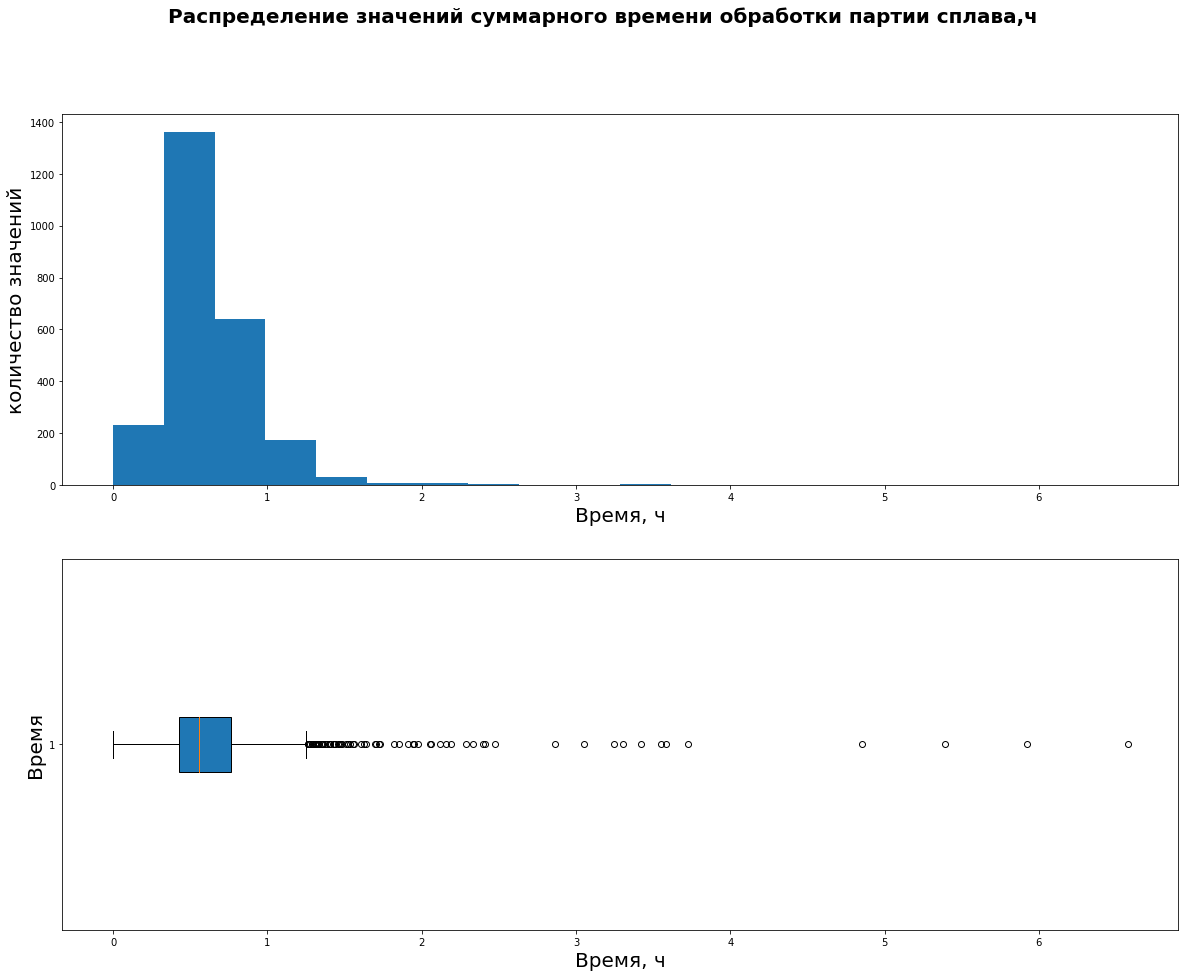

In [111]:
fig = plt.figure(figsize = (20,15))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(data_temp_new_fin['Общее время ТП'],bins = 20)
ax2.boxplot(data_temp_new_fin['Общее время ТП'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений суммарного времени обработки партии сплава,ч', fontsize=20, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Время, ч');
ax2.set(ylabel = 'Время', xlabel = 'Время, ч');

### Данные о проволочных материалах (дм3)

In [112]:
display(data_wire_new.info())
display(data_wire_new.head())
data_wire_new.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [113]:
data_wire_new.duplicated().sum()

0

Полных дубликатов нет.

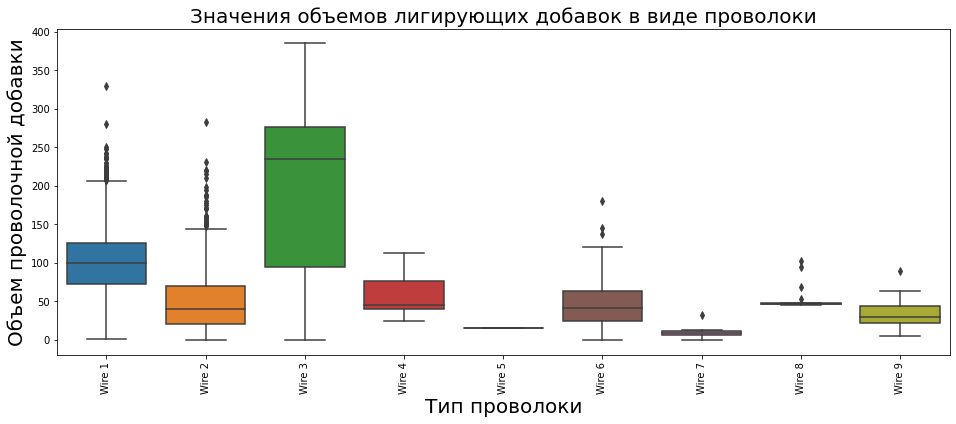

In [115]:
data_wire_new_1 = data_wire_new.drop(columns=['key'])
plt.figure(figsize=(16, 6)) 
bp = sns.boxplot(data = data_wire_new_1)

bp.set_title ('Значения объемов лигирующих добавок в виде проволоки');
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);
bp.set_ylabel('Объем проволочной добавки');
bp.set_xlabel('Тип проволоки');
plt.show();

Критичных аномальных значений не видно,оставим датасет как есть, только пропуски значений заменим нулями по аналогии с датасетом для сыпучей добавки.

In [116]:
data_wire_new_fin= data_wire_new.fillna(0)

In [117]:
data_wire_new_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [118]:
data_wire_new_fin.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2  96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3  91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4  89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5  89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

   Wire 9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

In [119]:
data_wire_new_fin.describe()

key       Wire 1       Wire 2       Wire 3       Wire 4  \
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000   
mean   1623.426485   100.044411    17.712733     3.874524     0.261019   
std     932.996726    42.841120    33.517734    30.310417     4.293865   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%     823.000000    70.281120     0.000000     0.000000     0.000000   
50%    1619.000000   100.114563     0.000000     0.000000     0.000000   
75%    2434.000000   125.798405    23.162880     0.000000     0.000000   
max    3241.000000   330.314424   282.780152   385.008668   113.231044   

            Wire 5       Wire 6       Wire 7       Wire 8       Wire 9  
count  3081.000000  3081.000000  3081.000000  3081.000000  3081.000000  
mean      0.004911     1.137695     0.035842     0.330697     0.321492  
std       0.272615     8.958111     0.774190     4.392677     3.806904  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max      15.132000   180.454575    32.847674   102.762401    90.053604

Отлично, пропуски заменены нулями. Но после добавления нулей,изменилось распределение значений некоторых параметров, там, где было много пропусков и добавка редко использовалась.

### данные о проволочных материалах (время)

Датафрейм содержит информацию о времени и дате введения проволочной лигирующей добавки каждого типа и является дополнением таблицы data_wire_new.

In [120]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [121]:
data_wire_time_new.head(6)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN

Так как данные различных датафреймов рассоглассованы по времени, таблица не понадобится.

### Сформируем общий датафрейм

Объединение будем производить по общим номерам партий:

In [122]:
df_1 = pd.merge(data_temp_new_fin,data_gas_new,how = 'inner', on = 'key')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2470
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2471 non-null   int64  
 1   Начальная Т     2471 non-null   float64
 2   Конечная Т      2471 non-null   float64
 3   Общее время ТП  2471 non-null   float64
 4   Газ 1           2471 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 115.8 KB


In [123]:
df_2 = pd.merge(df_1,df_arc_fin,how = 'inner', on = 'key')
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2468 entries, 0 to 2467
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2468 non-null   int64  
 1   Начальная Т             2468 non-null   float64
 2   Конечная Т              2468 non-null   float64
 3   Общее время ТП          2468 non-null   float64
 4   Газ 1                   2468 non-null   float64
 5   Время работы электрода  2468 non-null   float64
 6   Энергопотребление       2468 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 154.2 KB


In [124]:
df_3 = pd.merge(df_2,data_bulk_new_fin,how = 'inner', on = 'key')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 0 to 2399
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2400 non-null   int64  
 1   Начальная Т             2400 non-null   float64
 2   Конечная Т              2400 non-null   float64
 3   Общее время ТП          2400 non-null   float64
 4   Газ 1                   2400 non-null   float64
 5   Время работы электрода  2400 non-null   float64
 6   Энергопотребление       2400 non-null   float64
 7   Bulk 1                  2400 non-null   float64
 8   Bulk 2                  2400 non-null   float64
 9   Bulk 3                  2400 non-null   float64
 10  Bulk 4                  2400 non-null   float64
 11  Bulk 5                  2400 non-null   float64
 12  Bulk 6                  2400 non-null   float64
 13  Bulk 7                  2400 non-null   float64
 14  Bulk 8                  2400 non-null   

In [125]:
df = pd.merge(df_3,data_wire_new_fin,how = 'inner', on = 'key')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2324 non-null   int64  
 1   Начальная Т             2324 non-null   float64
 2   Конечная Т              2324 non-null   float64
 3   Общее время ТП          2324 non-null   float64
 4   Газ 1                   2324 non-null   float64
 5   Время работы электрода  2324 non-null   float64
 6   Энергопотребление       2324 non-null   float64
 7   Bulk 1                  2324 non-null   float64
 8   Bulk 2                  2324 non-null   float64
 9   Bulk 3                  2324 non-null   float64
 10  Bulk 4                  2324 non-null   float64
 11  Bulk 5                  2324 non-null   float64
 12  Bulk 6                  2324 non-null   float64
 13  Bulk 7                  2324 non-null   float64
 14  Bulk 8                  2324 non-null   

Получили датафрейм размером 2324 строк на 32 столбца, пропущенных значений нет.

In [126]:
df.describe()

key  Начальная Т   Конечная Т  Общее время ТП        Газ 1  \
count  2324.000000  2324.000000  2324.000000     2324.000000  2324.000000   
mean   1251.140275  1587.368761  1593.372633        0.645467    11.378854   
std     715.027927    23.627590    11.207457        0.384947     6.397008   
min       1.000000  1519.000000  1541.000000        0.094167     0.008399   
25%     628.750000  1571.000000  1587.000000        0.439028     7.282534   
50%    1254.500000  1587.000000  1593.000000        0.568472    10.100687   
75%    1867.250000  1603.000000  1598.000000        0.775972    14.218487   
max    2499.000000  1660.000000  1653.000000        6.576111    77.995040   

       Время работы электрода  Энергопотребление       Bulk 1       Bulk 2  \
count             2324.000000        2324.000000  2324.000000  2324.000000   
mean                 0.224499           1.362703     3.435026     1.425559   
std                  0.094671           1.179401    12.424463    19.102530   
min                  0.015833           0.013046     0.000000     0.000000   
25%                  0.161389           0.664423     0.000000     0.000000   
50%                  0.216111           1.128637     0.000000     0.000000   
75%                  0.275833           1.752691     0.000000     0.000000   
max                  1.163611          24.813640   185.000000   325.000000   

            Bulk 3  ...      Bulk 15       Wire 1       Wire 2       Wire 3  \
count  2324.000000  ...  2324.000000  2324.000000  2324.000000  2324.000000   
mean     47.317126  ...   120.078313   102.423900    17.613213     3.241876   
std      75.238050  ...    84.655967    43.540975    33.648176    27.972523   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     0.000000    73.204559     0.000000     0.000000   
50%       0.000000  ...   107.000000   101.103600     0.000000     0.000000   
75%      80.000000  ...   204.000000   128.075222    23.102560     0.000000   
max     454.000000  ...   405.000000   330.314424   282.780152   385.008668   

            Wire 4  Wire 5       Wire 6       Wire 7       Wire 8       Wire 9  
count  2324.000000  2324.0  2324.000000  2324.000000  2324.000000  2324.000000  
mean      0.307209     0.0     0.980926     0.006374     0.311981     0.317795  
std       4.762842     0.0     8.702531     0.205926     4.407419     3.460248  
min       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
max     113.231044     0.0   180.454575     8.490040   102.762401    62.025600  

[8 rows x 31 columns]

При заполнение нулями пропусков в датасетах добавок произошло смещение распределения значений у тех добавок, в которых было мало данных (редкоприменяемые добавки).

In [127]:
df.describe()

key  Начальная Т   Конечная Т  Общее время ТП        Газ 1  \
count  2324.000000  2324.000000  2324.000000     2324.000000  2324.000000   
mean   1251.140275  1587.368761  1593.372633        0.645467    11.378854   
std     715.027927    23.627590    11.207457        0.384947     6.397008   
min       1.000000  1519.000000  1541.000000        0.094167     0.008399   
25%     628.750000  1571.000000  1587.000000        0.439028     7.282534   
50%    1254.500000  1587.000000  1593.000000        0.568472    10.100687   
75%    1867.250000  1603.000000  1598.000000        0.775972    14.218487   
max    2499.000000  1660.000000  1653.000000        6.576111    77.995040   

       Время работы электрода  Энергопотребление       Bulk 1       Bulk 2  \
count             2324.000000        2324.000000  2324.000000  2324.000000   
mean                 0.224499           1.362703     3.435026     1.425559   
std                  0.094671           1.179401    12.424463    19.102530   
min                  0.015833           0.013046     0.000000     0.000000   
25%                  0.161389           0.664423     0.000000     0.000000   
50%                  0.216111           1.128637     0.000000     0.000000   
75%                  0.275833           1.752691     0.000000     0.000000   
max                  1.163611          24.813640   185.000000   325.000000   

            Bulk 3  ...      Bulk 15       Wire 1       Wire 2       Wire 3  \
count  2324.000000  ...  2324.000000  2324.000000  2324.000000  2324.000000   
mean     47.317126  ...   120.078313   102.423900    17.613213     3.241876   
std      75.238050  ...    84.655967    43.540975    33.648176    27.972523   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     0.000000    73.204559     0.000000     0.000000   
50%       0.000000  ...   107.000000   101.103600     0.000000     0.000000   
75%      80.000000  ...   204.000000   128.075222    23.102560     0.000000   
max     454.000000  ...   405.000000   330.314424   282.780152   385.008668   

            Wire 4  Wire 5       Wire 6       Wire 7       Wire 8       Wire 9  
count  2324.000000  2324.0  2324.000000  2324.000000  2324.000000  2324.000000  
mean      0.307209     0.0     0.980926     0.006374     0.311981     0.317795  
std       4.762842     0.0     8.702531     0.205926     4.407419     3.460248  
min       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.0     0.000000     0.000000     0.000000     0.000000  
max     113.231044     0.0   180.454575     8.490040   102.762401    62.025600  

[8 rows x 31 columns]

In [128]:
df.isna().sum()

key                       0
Начальная Т               0
Конечная Т                0
Общее время ТП            0
Газ 1                     0
Время работы электрода    0
Энергопотребление         0
Bulk 1                    0
Bulk 2                    0
Bulk 3                    0
Bulk 4                    0
Bulk 5                    0
Bulk 6                    0
Bulk 7                    0
Bulk 8                    0
Bulk 9                    0
Bulk 10                   0
Bulk 11                   0
Bulk 12                   0
Bulk 13                   0
Bulk 14                   0
Bulk 15                   0
Wire 1                    0
Wire 2                    0
Wire 3                    0
Wire 4                    0
Wire 5                    0
Wire 6                    0
Wire 7                    0
Wire 8                    0
Wire 9                    0
dtype: int64

In [129]:
df = df.drop(columns = ['key'])

Пропущенных значений нет.

На тепловой диаграмме коэффициента Пирсона обнаружена линейная зависимость между Wire 7 и Bulk 2, Wire 7 и Bulk 7, Wire 7 и Bulk 9,Bulk 7 и Bulk 2, Bulk 9 и Wire 8. Удалим одно из зависимых значений.

In [130]:
df = df.drop(columns = ['Wire 4','Wire 5','Bulk 7','Bulk 2','Bulk 9'])

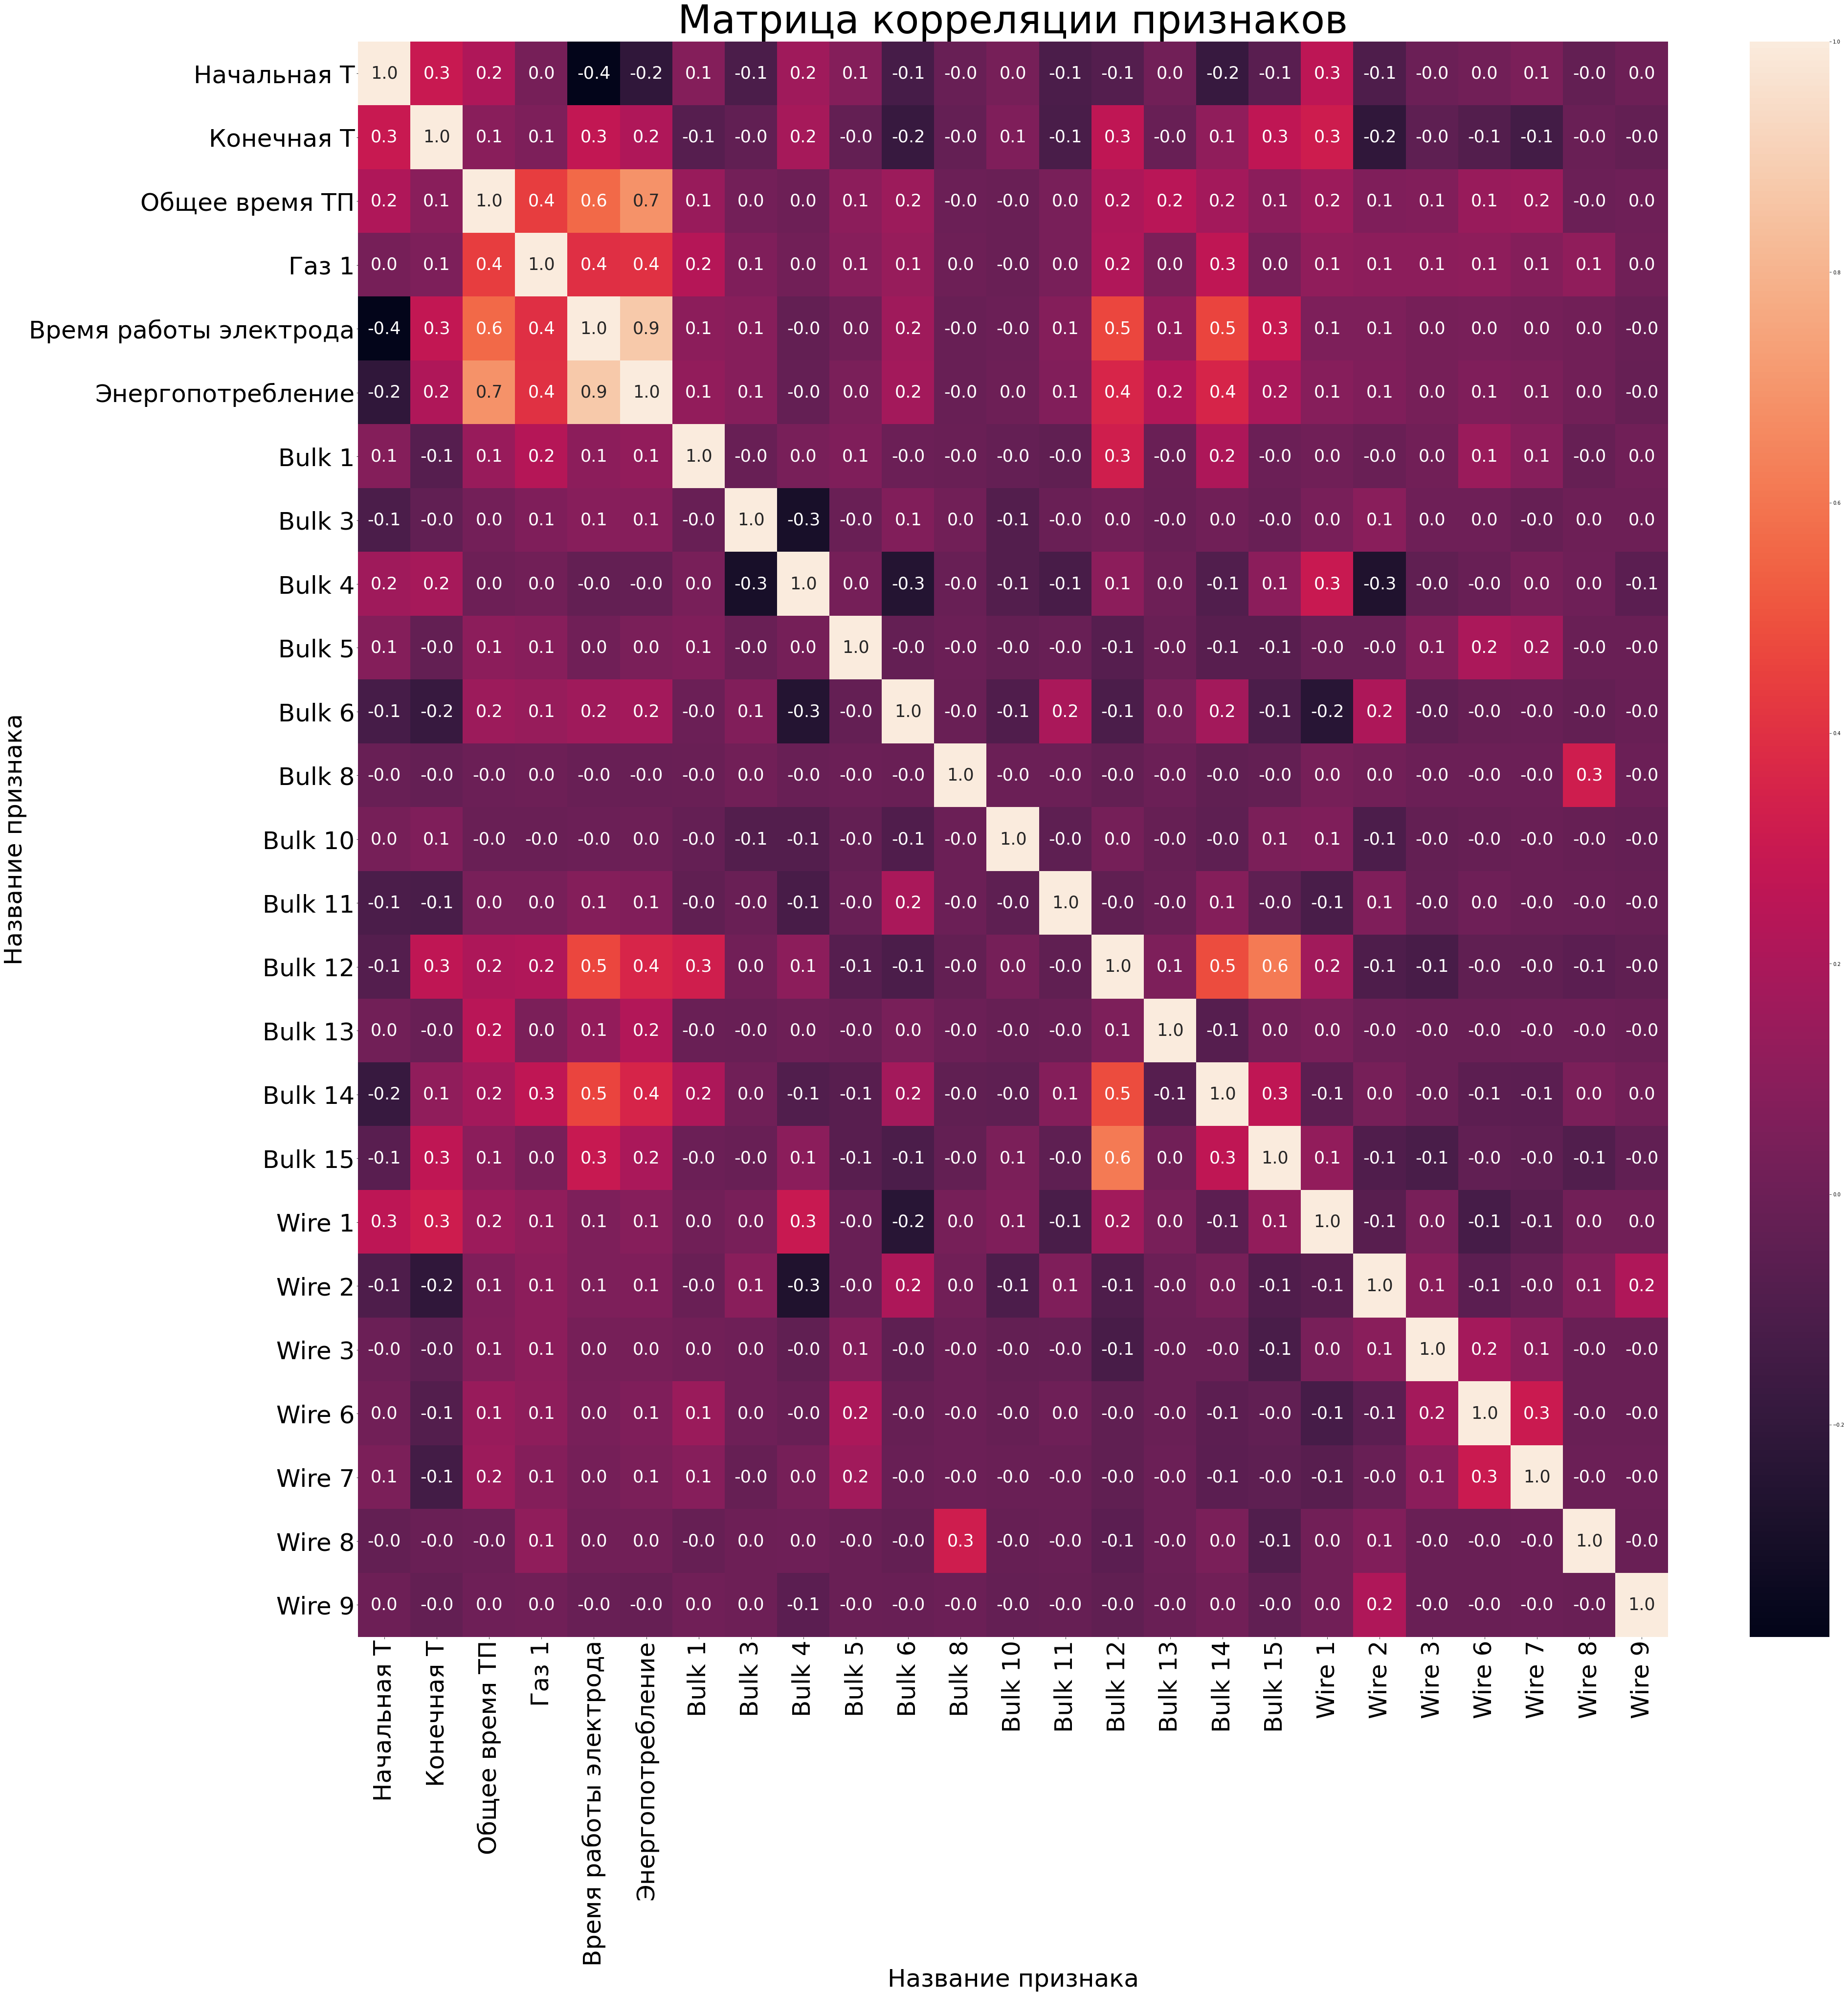

In [131]:
fig, ax = plt.subplots(figsize=(60,60))
ax1 =sns.heatmap(df.corr(),annot=True,fmt='.1f',annot_kws={'size':35})
ax1.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize = 50);
ax1.set_yticklabels(ax.get_yticklabels(),fontsize = 50);
sns.set(font_scale= 8)
plt.title('Матрица корреляции признаков', fontsize=80);
plt.ylabel('Название признака', fontsize=50);
plt.xlabel('Название признака', fontsize=50);
plt.show()

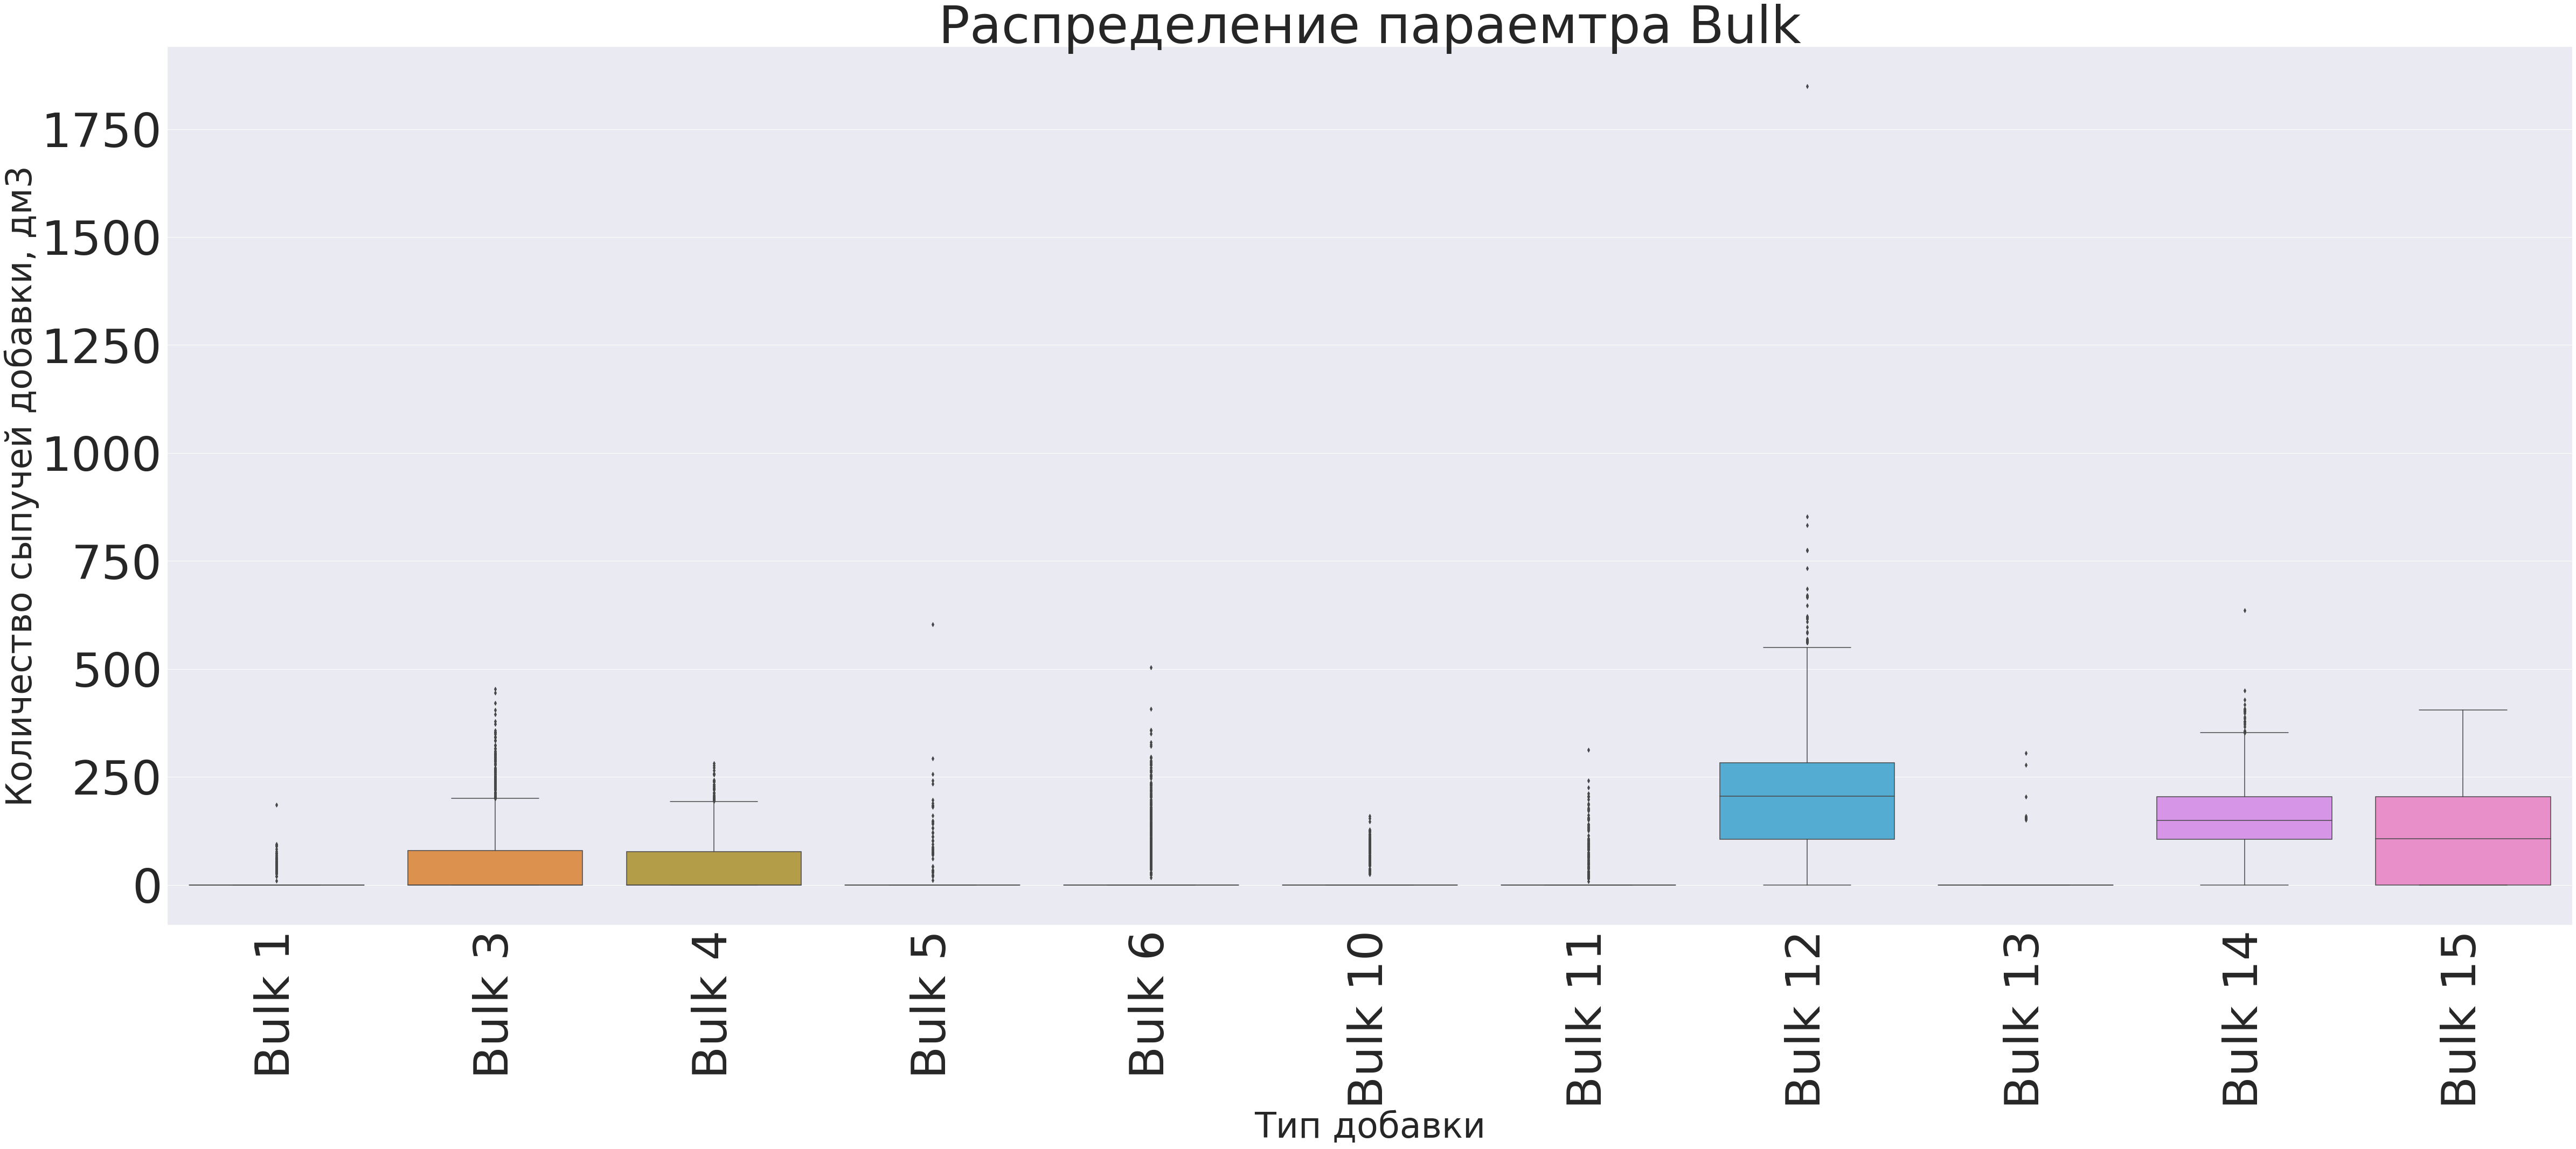

In [137]:
df_bulk = df[['Bulk 1','Bulk 3','Bulk 4','Bulk 5','Bulk 6','Bulk 10','Bulk 11','Bulk 12','Bulk 13','Bulk 14','Bulk 15']]
fig,ax = plt.subplots(figsize = (80,30)) 
bp = sns.boxplot(data = df_bulk)
bp.set_title ('Распределение параемтра Bulk');
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);
bp.set_ylabel('Количество сыпучей добавки, дм3',fontsize = 65);
bp.set_xlabel('Тип добавки',fontsize = 65);
plt.show();

У многих сыпучих добавок распределение ушло в 0, так как они редко применялись , но пока удалять их не будем.

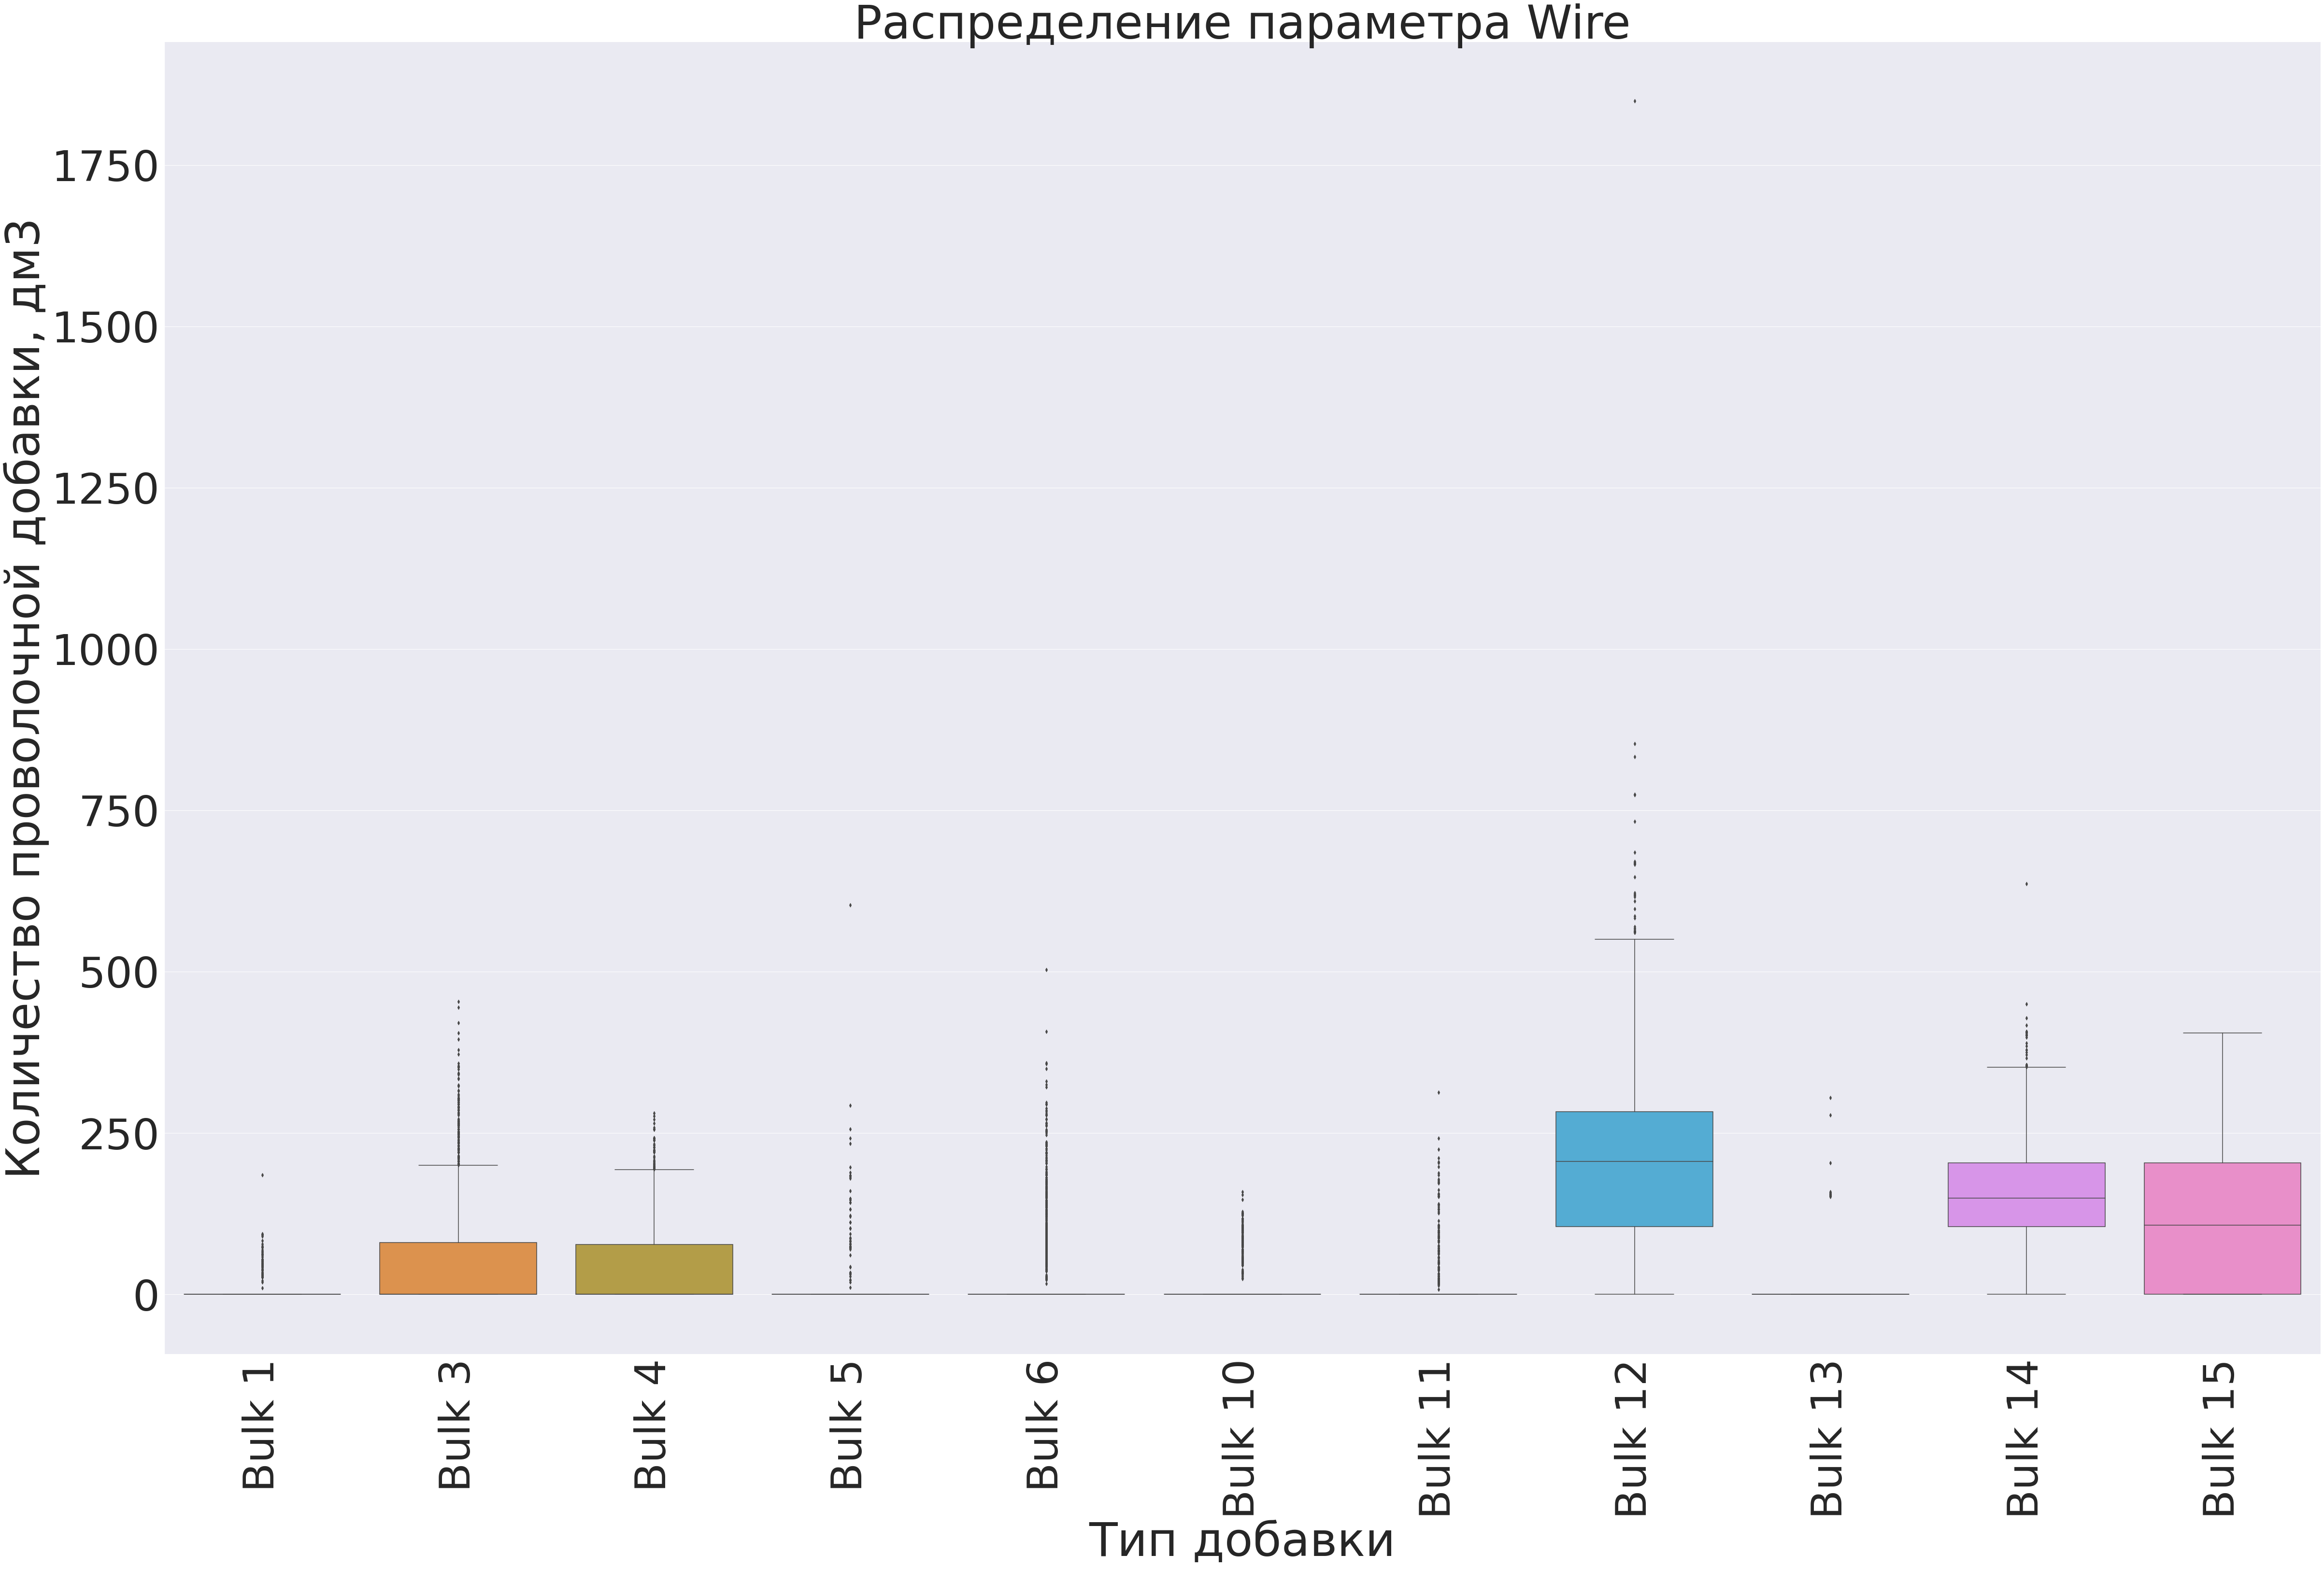

In [138]:
df_wire = df[['Wire 1','Wire 2','Wire 3','Wire 6','Wire 8','Wire 9','Wire 7']]
plt.figure(figsize = (80,50)) 
bp = sns.boxplot(data = df_bulk)
bp.set_title ('Распределение параметра Wire');
bp.set_xticklabels(bp.get_xticklabels(), rotation=90);
bp.set_ylabel('Количество проволочной добавки, дм3');
bp.set_xlabel('Тип добавки');
plt.show();

Та же картина в проволочной добавки, редкие экземпляры стали исчезающим видом.

Теперь посмотрим на распределение в начальных и конечных температурах стали:

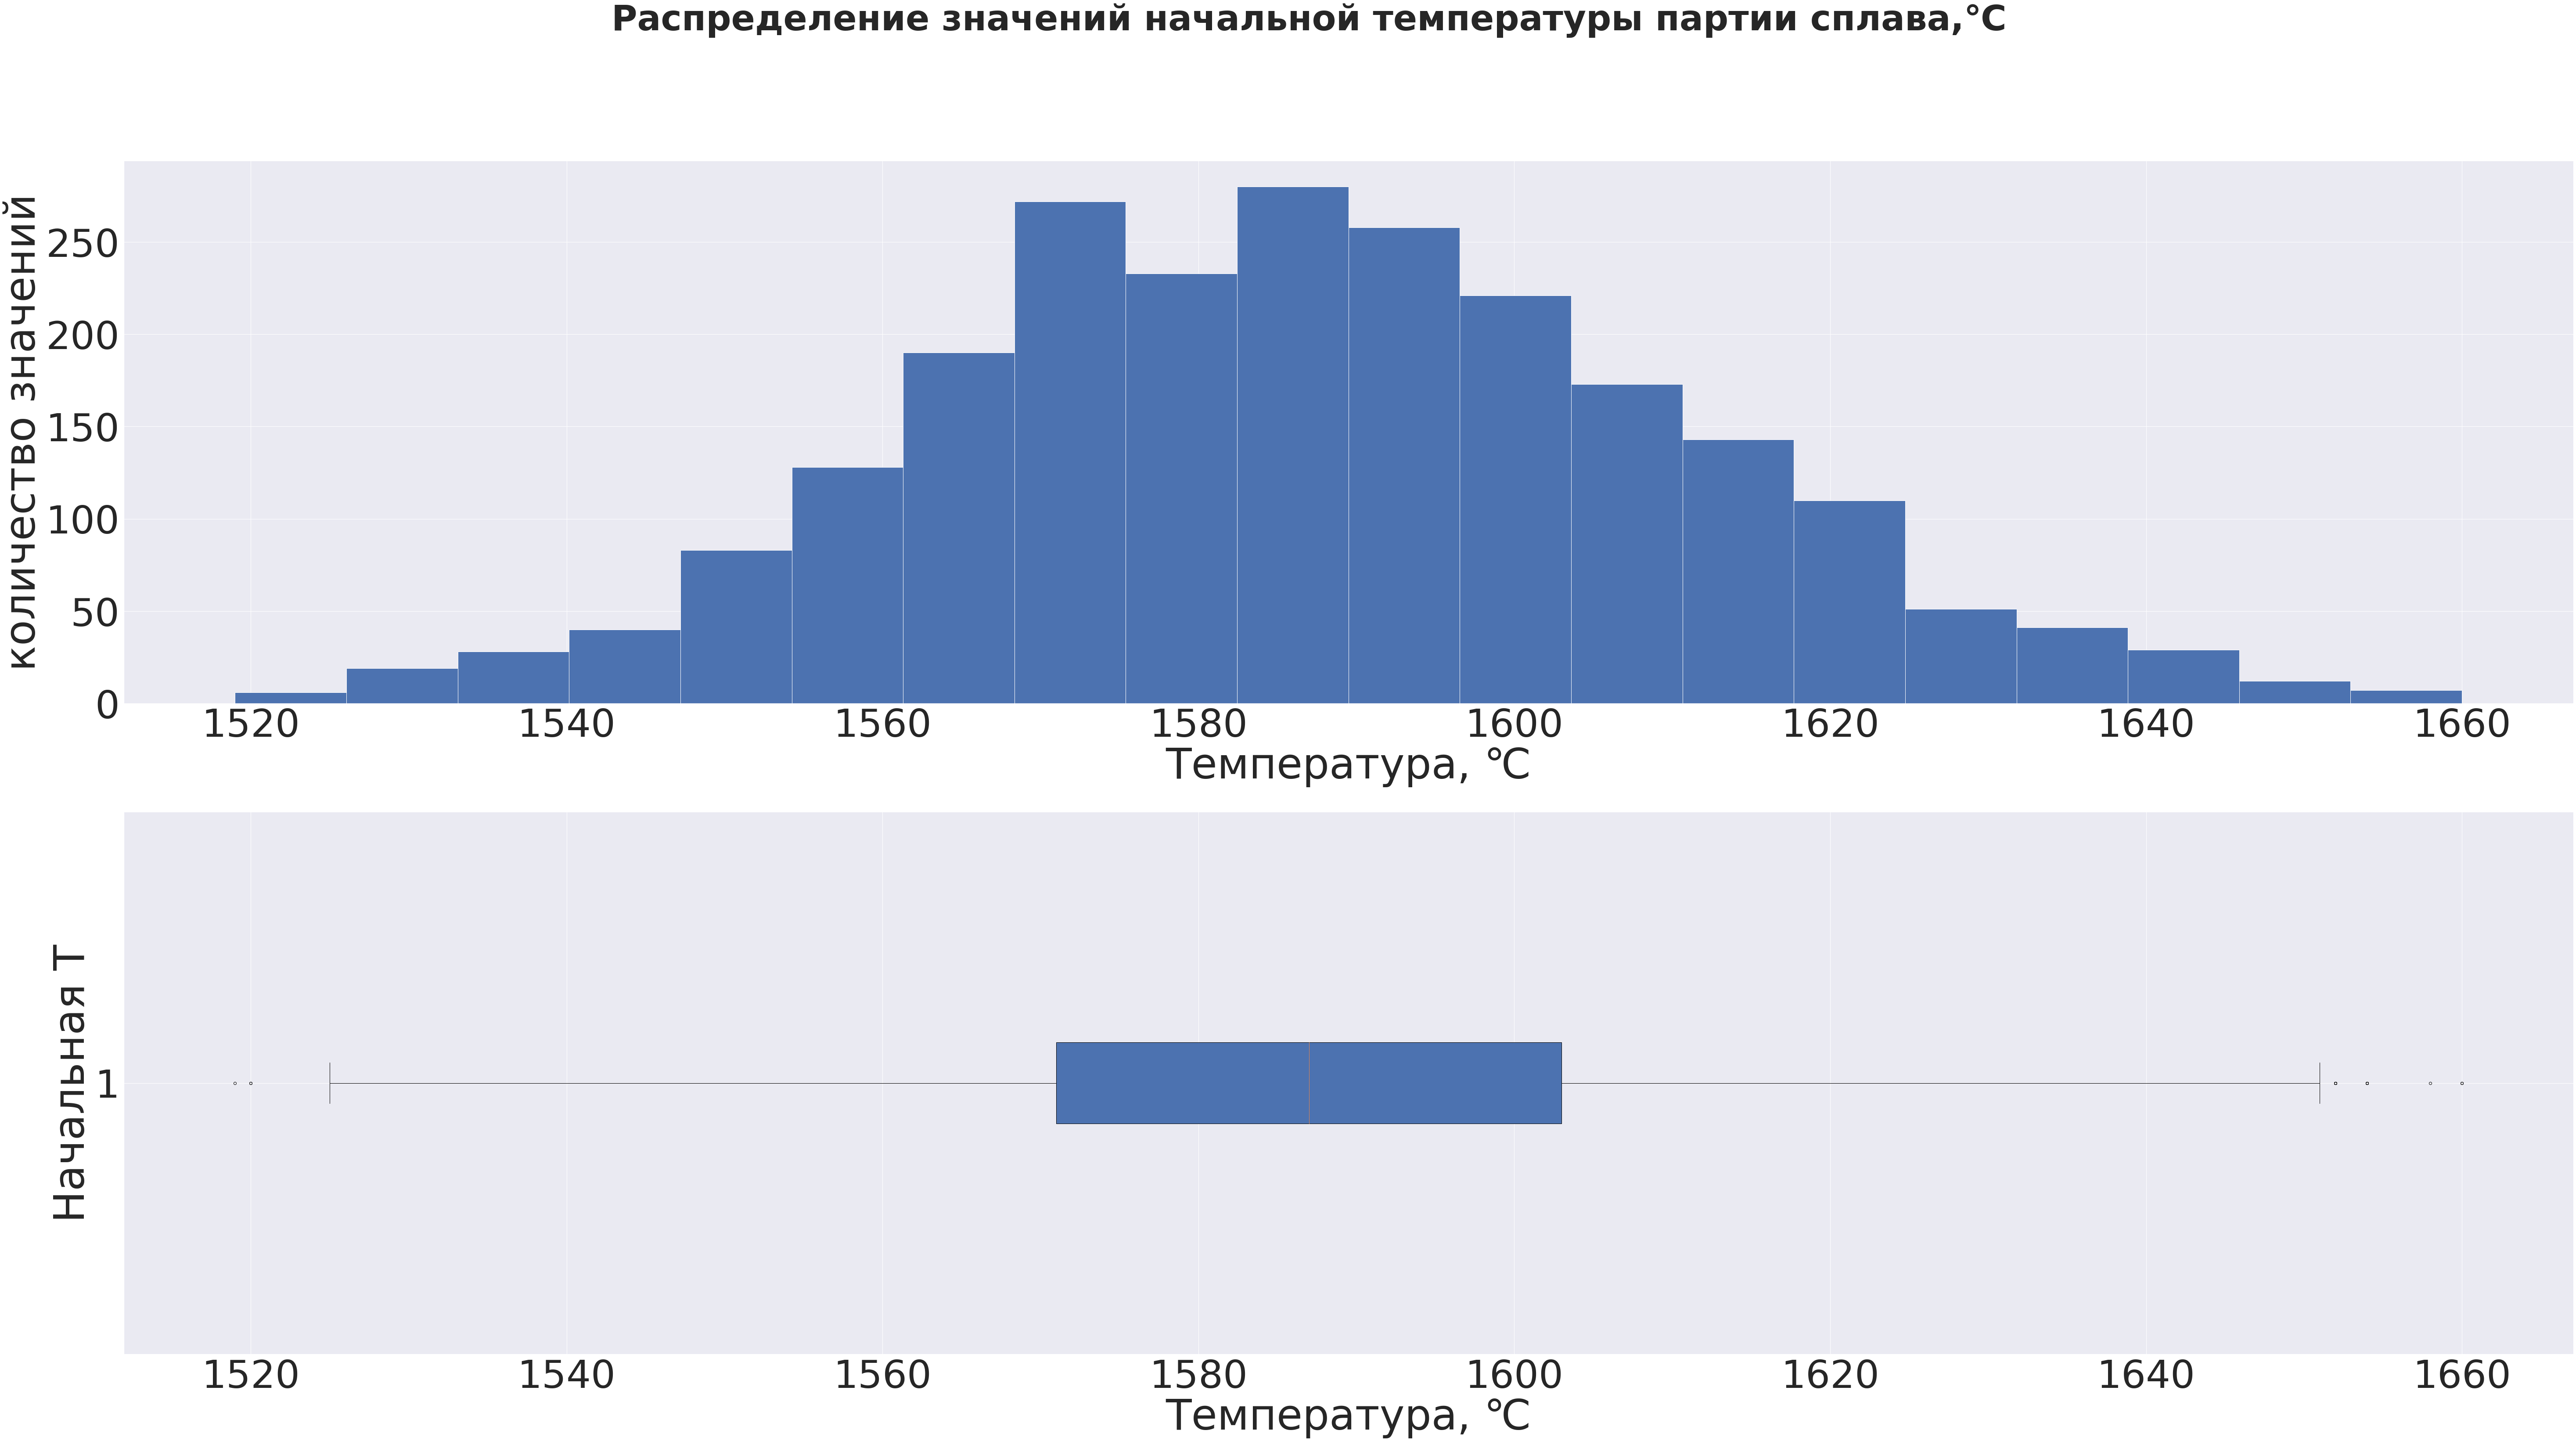

In [139]:
fig = plt.figure(figsize = (100,50))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df['Начальная Т'],bins = 20)
ax2.boxplot(df['Начальная Т'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений начальной температуры партии сплава,℃', fontsize=80, fontweight='bold');
ax1.set(ylabel = 'количество значений', xlabel = 'Температура, ℃');
ax2.set(ylabel = 'Начальная Т', xlabel = 'Температура, ℃');
plt.show();

Нормальное распределение, есть некоторые выбросы, но они в пределах разумного.

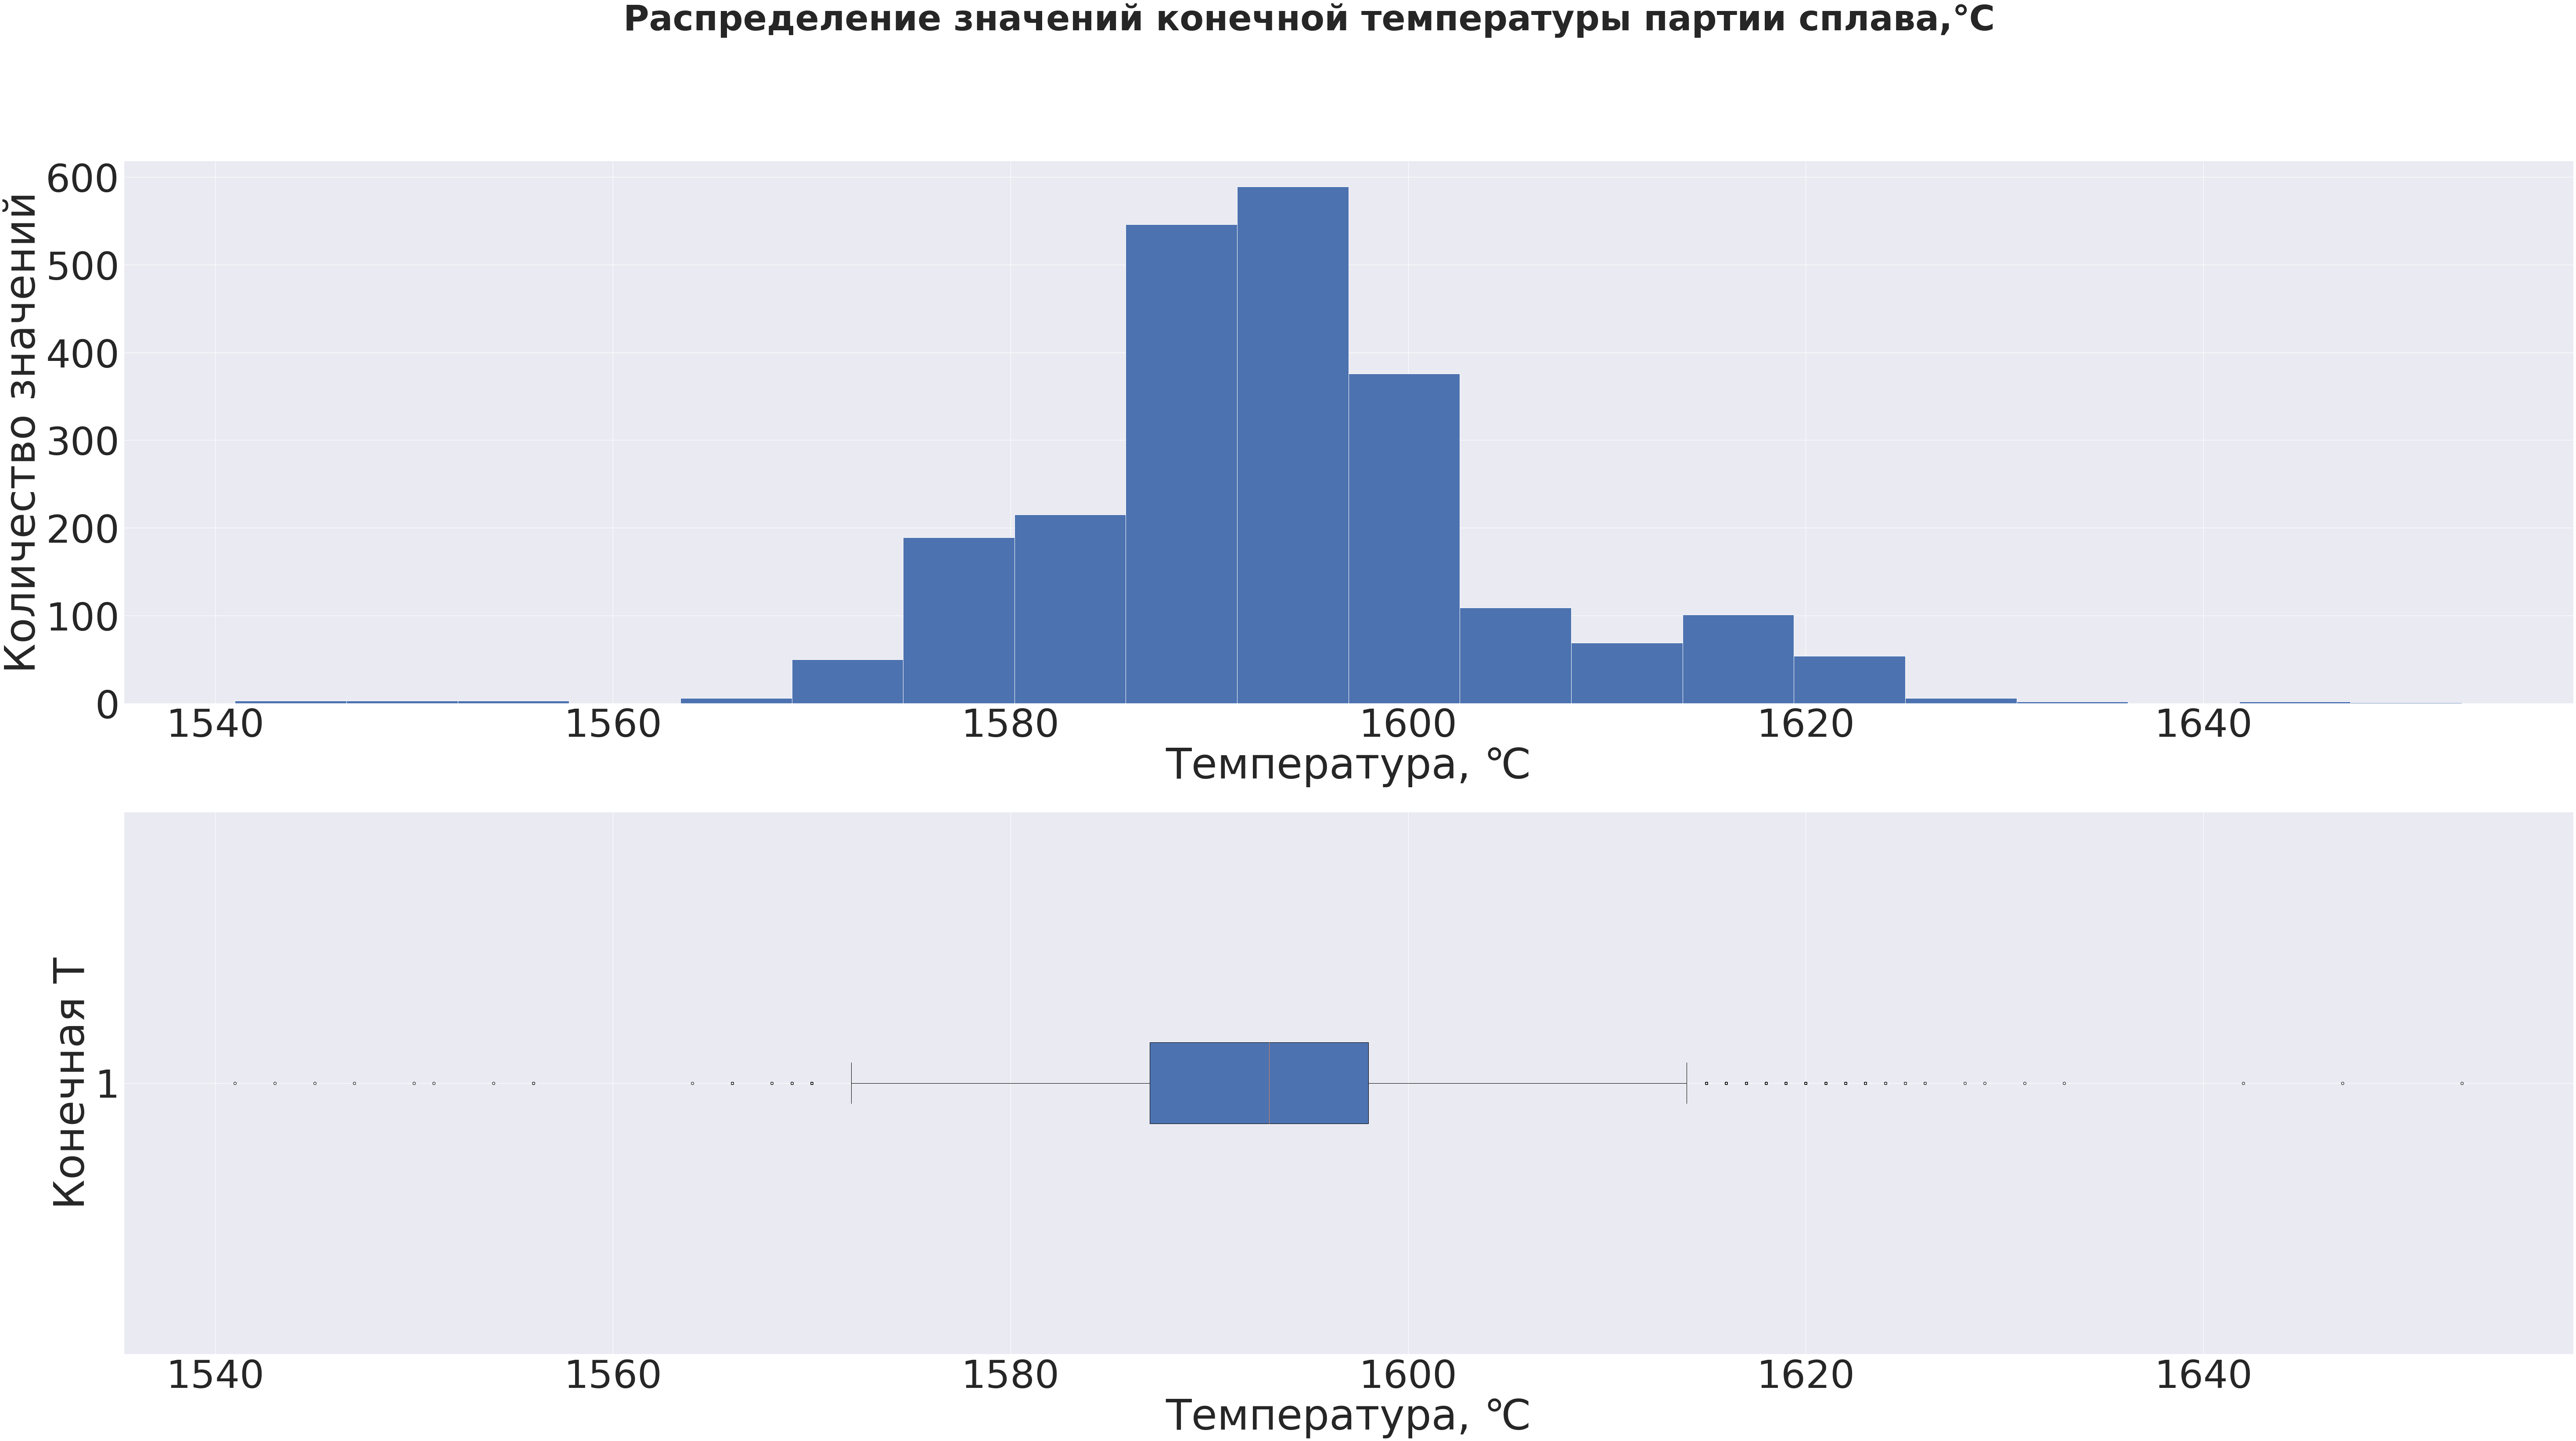

In [140]:
fig = plt.figure(figsize = (100,50))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df['Конечная Т'],bins = 20)
ax2.boxplot(df['Конечная Т'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений конечной температуры партии сплава,℃', fontsize=80, fontweight='bold');
ax1.set(ylabel = 'Количество значений', xlabel = 'Температура, ℃');
ax2.set(ylabel = 'Конечная Т', xlabel = 'Температура, ℃');
plt.show();

Та же картина, нормальное распределение с небольшими симметричными хвостиками. Оставляем.

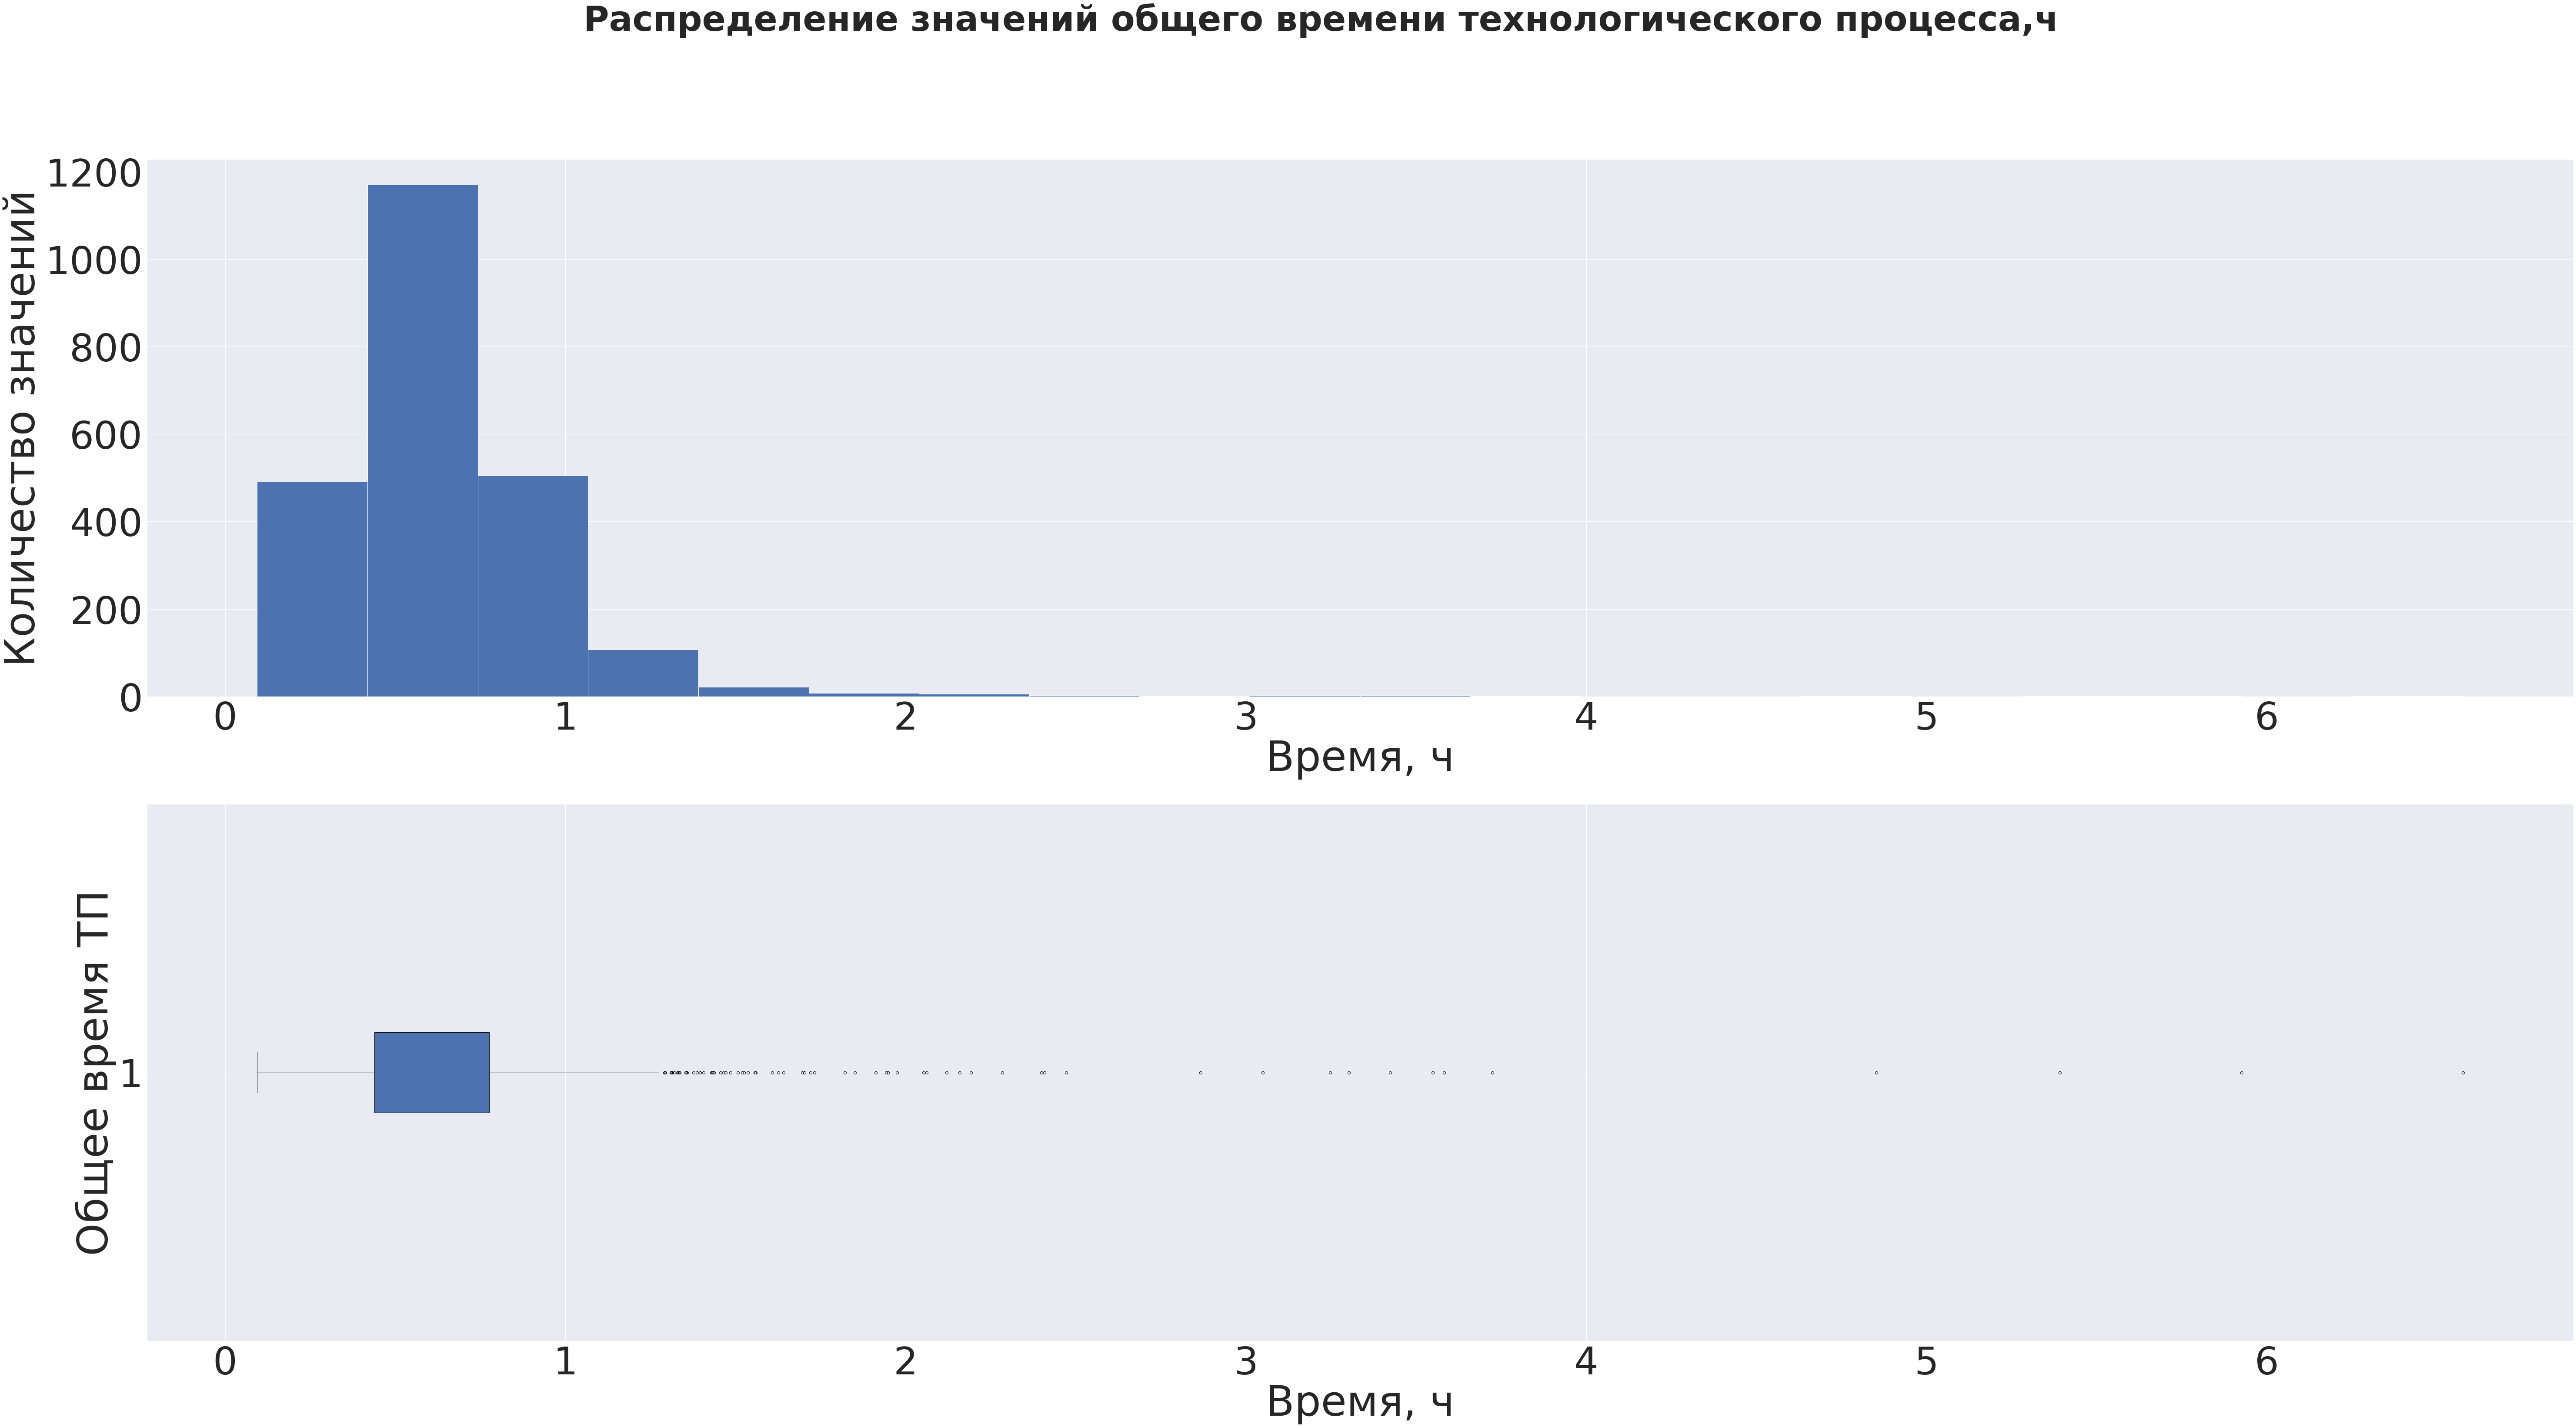

In [142]:
fig = plt.figure(figsize = (100,50))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df['Общее время ТП'],bins = 20)
ax2.boxplot(df['Общее время ТП'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений общего времени технологического процесса,ч', fontsize=80, fontweight='bold');
ax1.set(ylabel = 'Количество значений', xlabel = 'Время, ч');
ax2.set(ylabel = 'Общее время ТП', xlabel = 'Время, ч');
plt.show();

Основная масса длительности технологического процесса обработки стали в ковше составляет 0.5 часа, есть процессы длительностью более 3-х часов, но удалять их пока не будем, возможно это редкие добавки и редкие марки стали. Так же есть партии, где время между первым измерением температуры и последним равны 0, похоже на сбой.

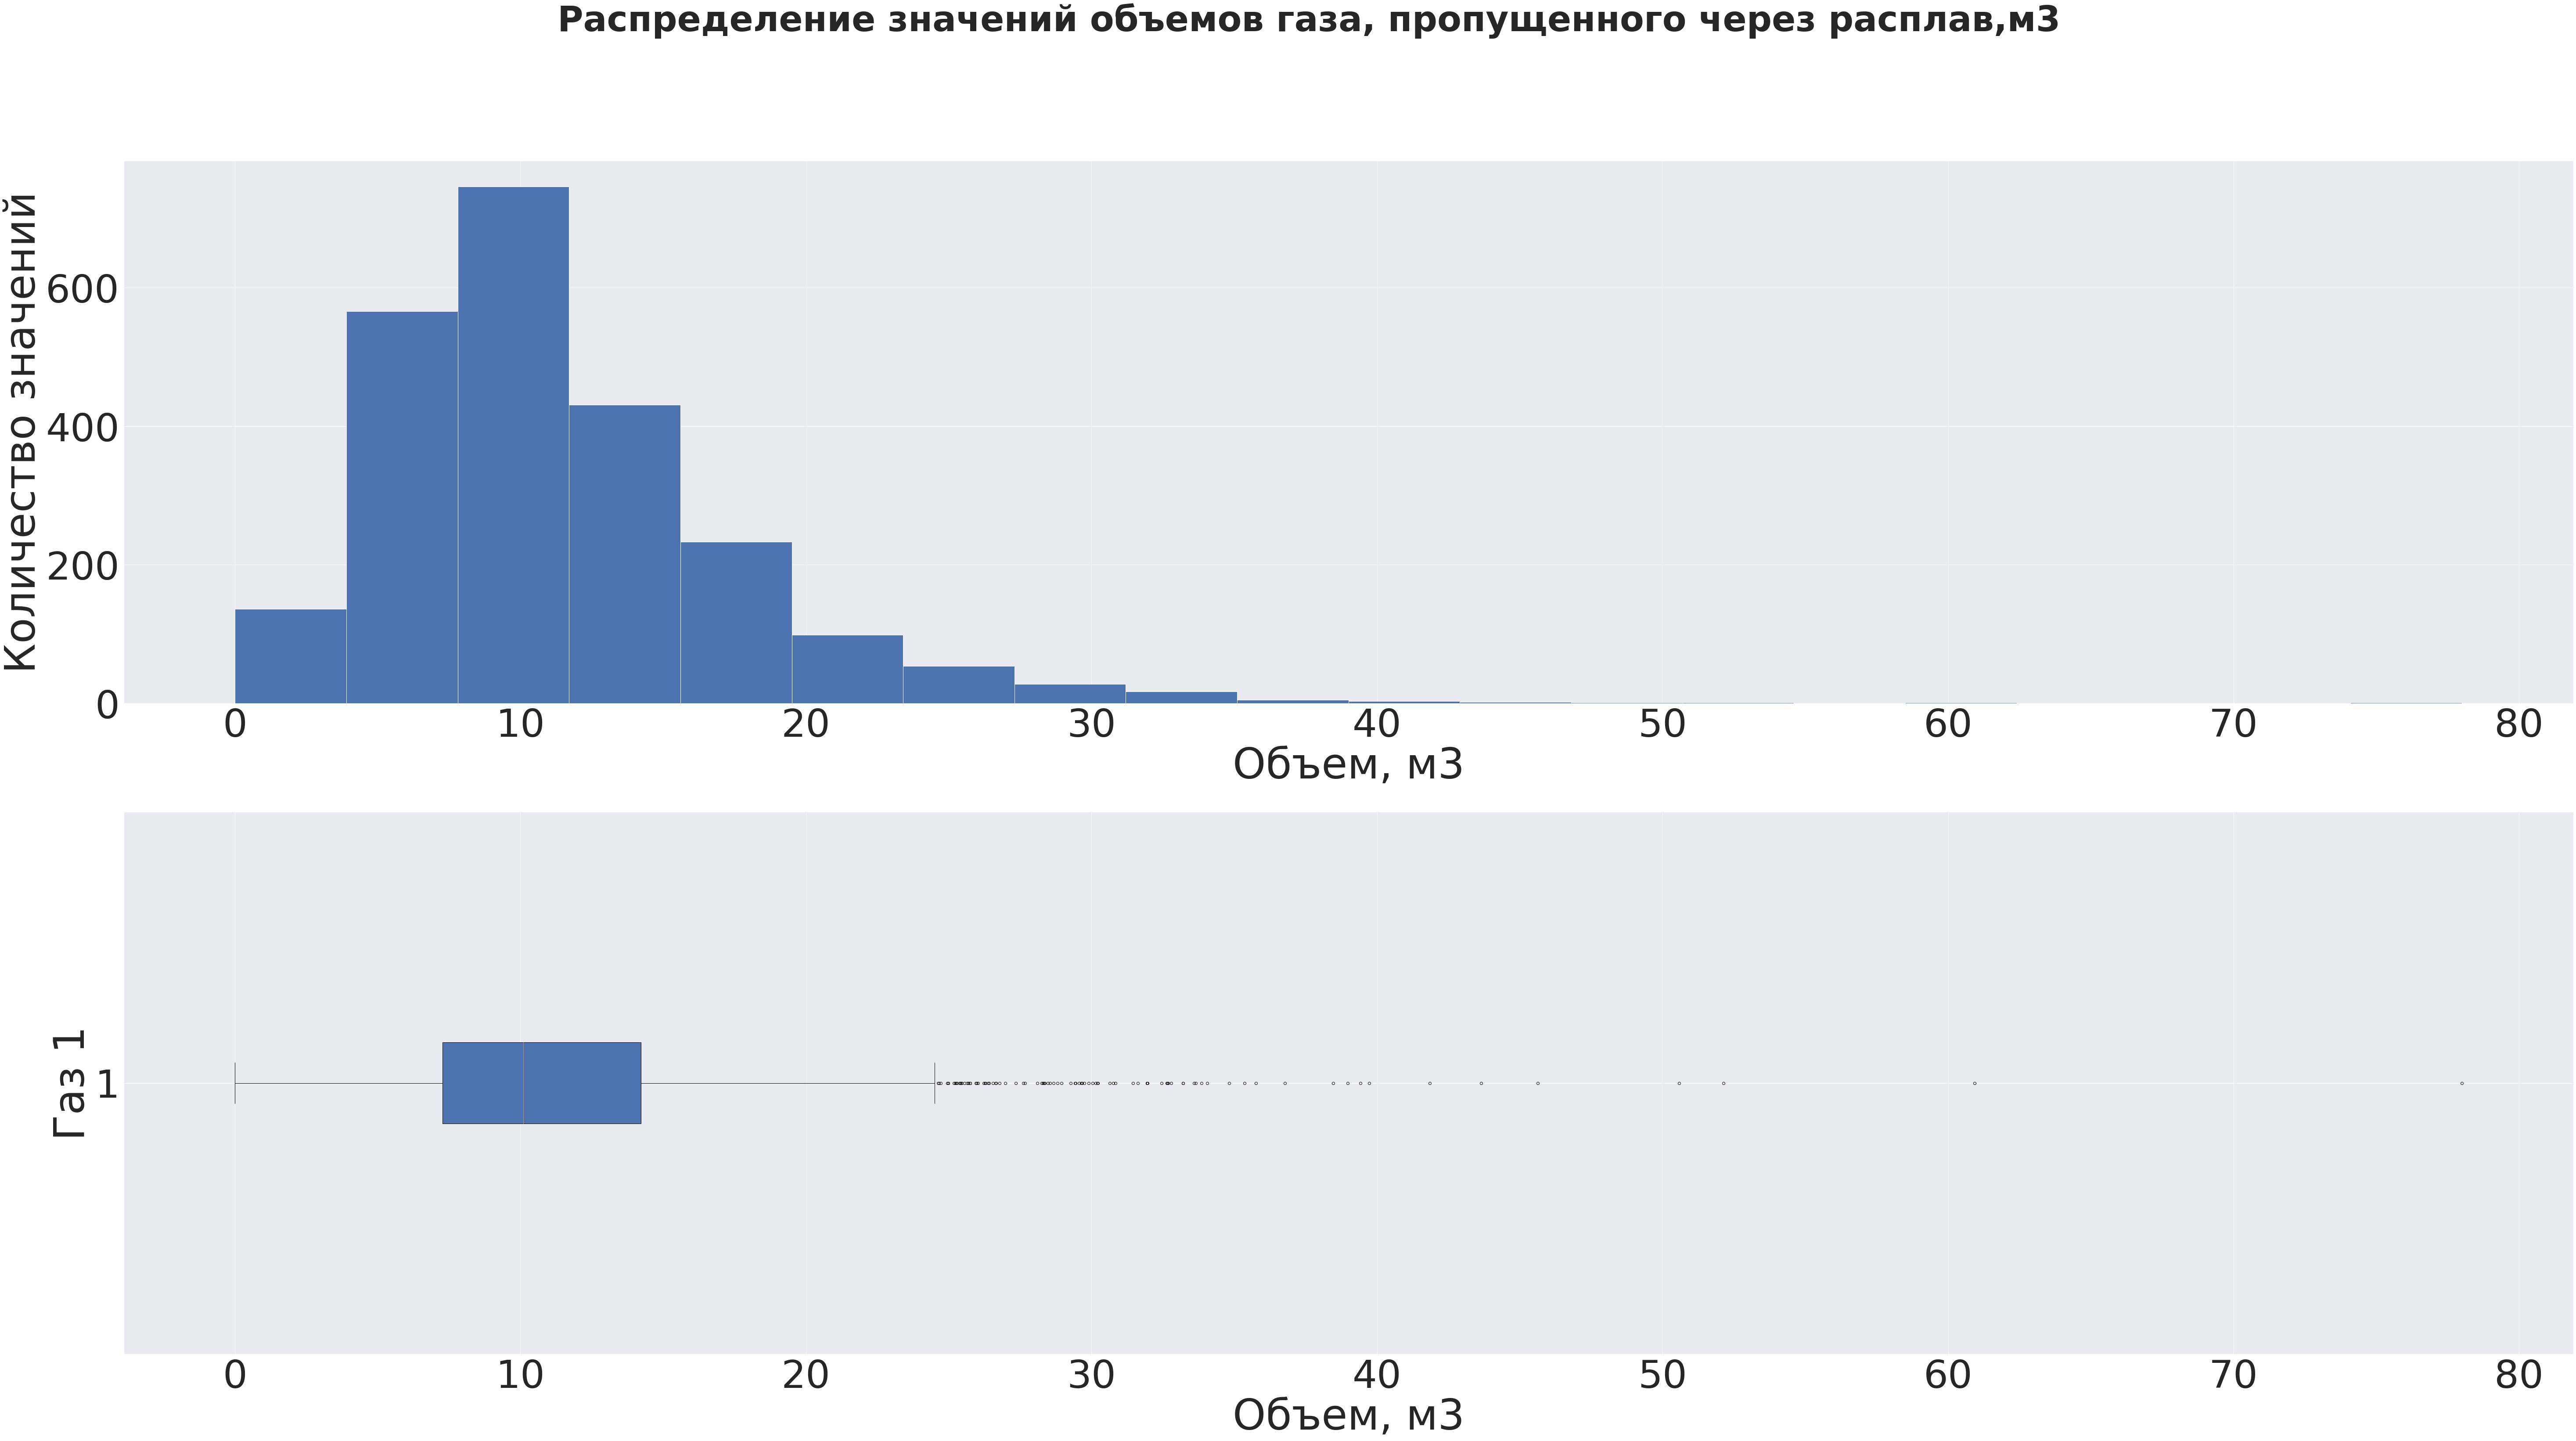

In [143]:
fig = plt.figure(figsize = (100,50))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df['Газ 1'],bins = 20)
ax2.boxplot(df['Газ 1'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений объемов газа, пропущенного через расплав,м3', fontsize=80, fontweight='bold');
ax1.set(ylabel = 'Количество значений', xlabel = 'Объем, м3');
ax2.set(ylabel = 'Газ 1', xlabel = 'Объем, м3');

Нормальное распределение и небольшой хвост до 60м3. Оставим.

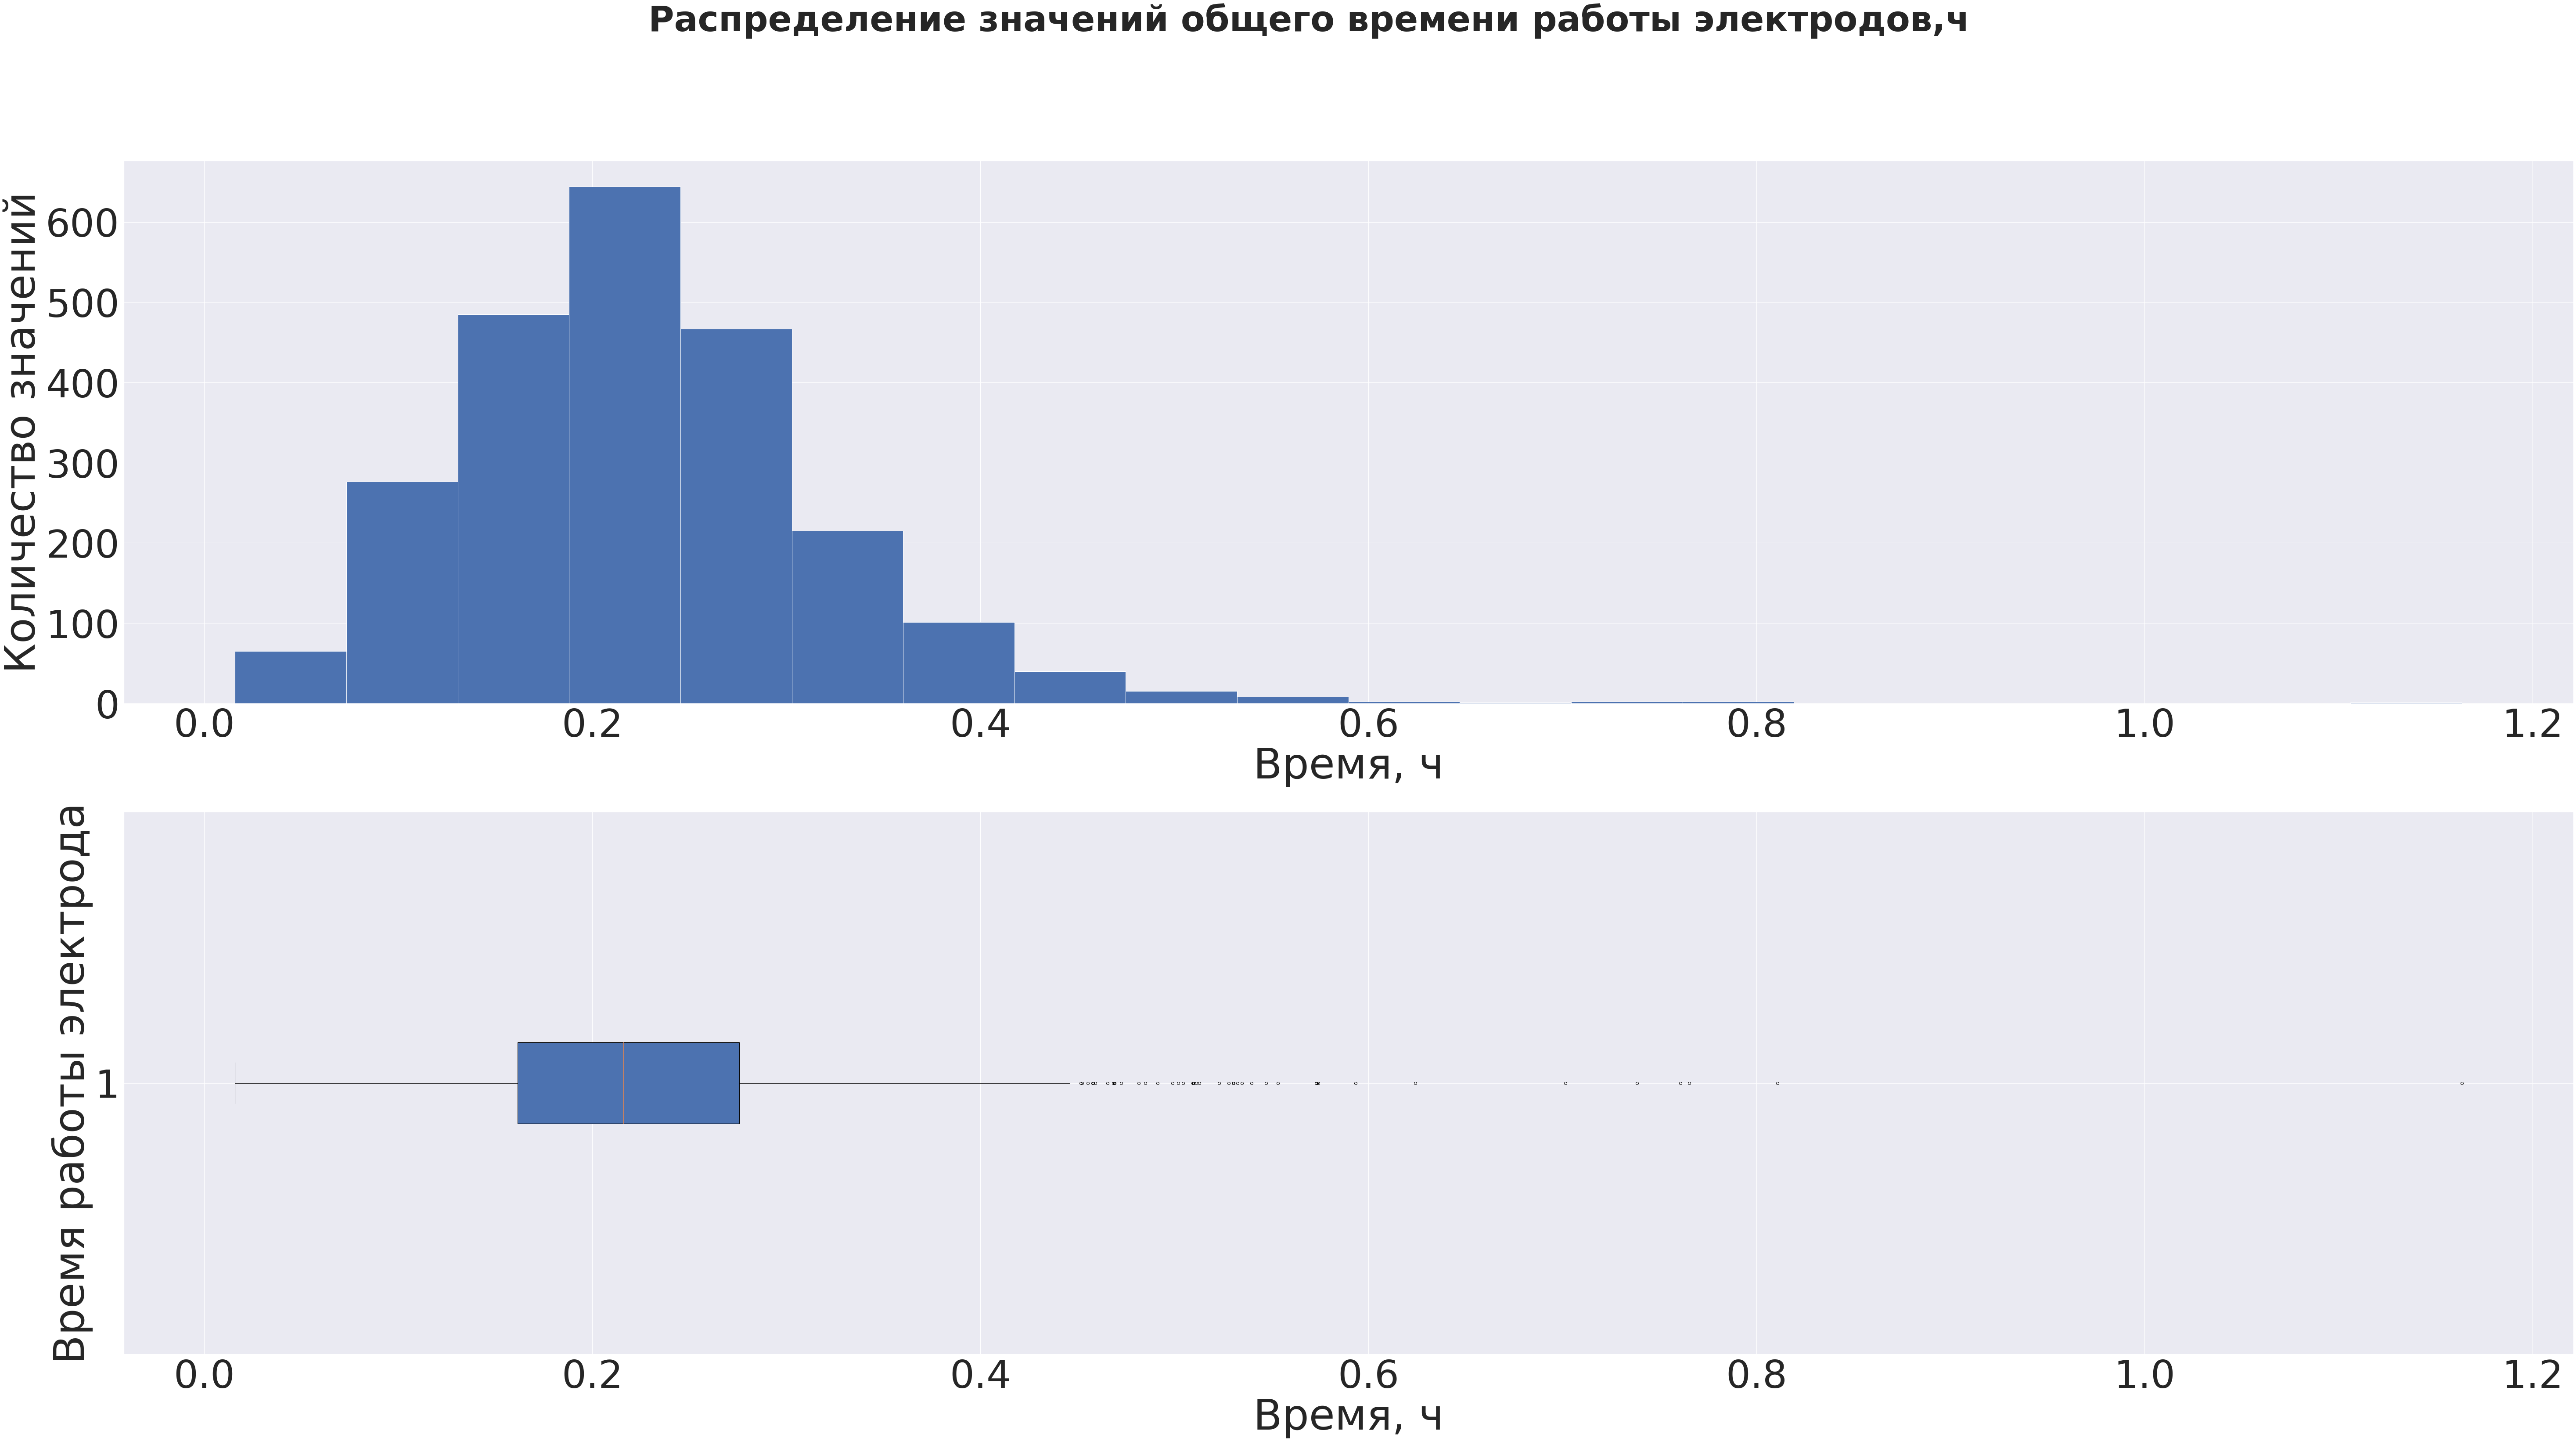

In [144]:
fig = plt.figure(figsize = (100,50))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df['Время работы электрода'],bins = 20)
ax2.boxplot(df['Время работы электрода'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений общего времени работы электродов,ч', fontsize=80, fontweight='bold');
ax1.set(ylabel = 'Количество значений', xlabel = 'Время, ч');
ax2.set(ylabel = 'Время работы электрода', xlabel = 'Время, ч');

👌Нормальное распределение с хвостом справа.Оставляем.

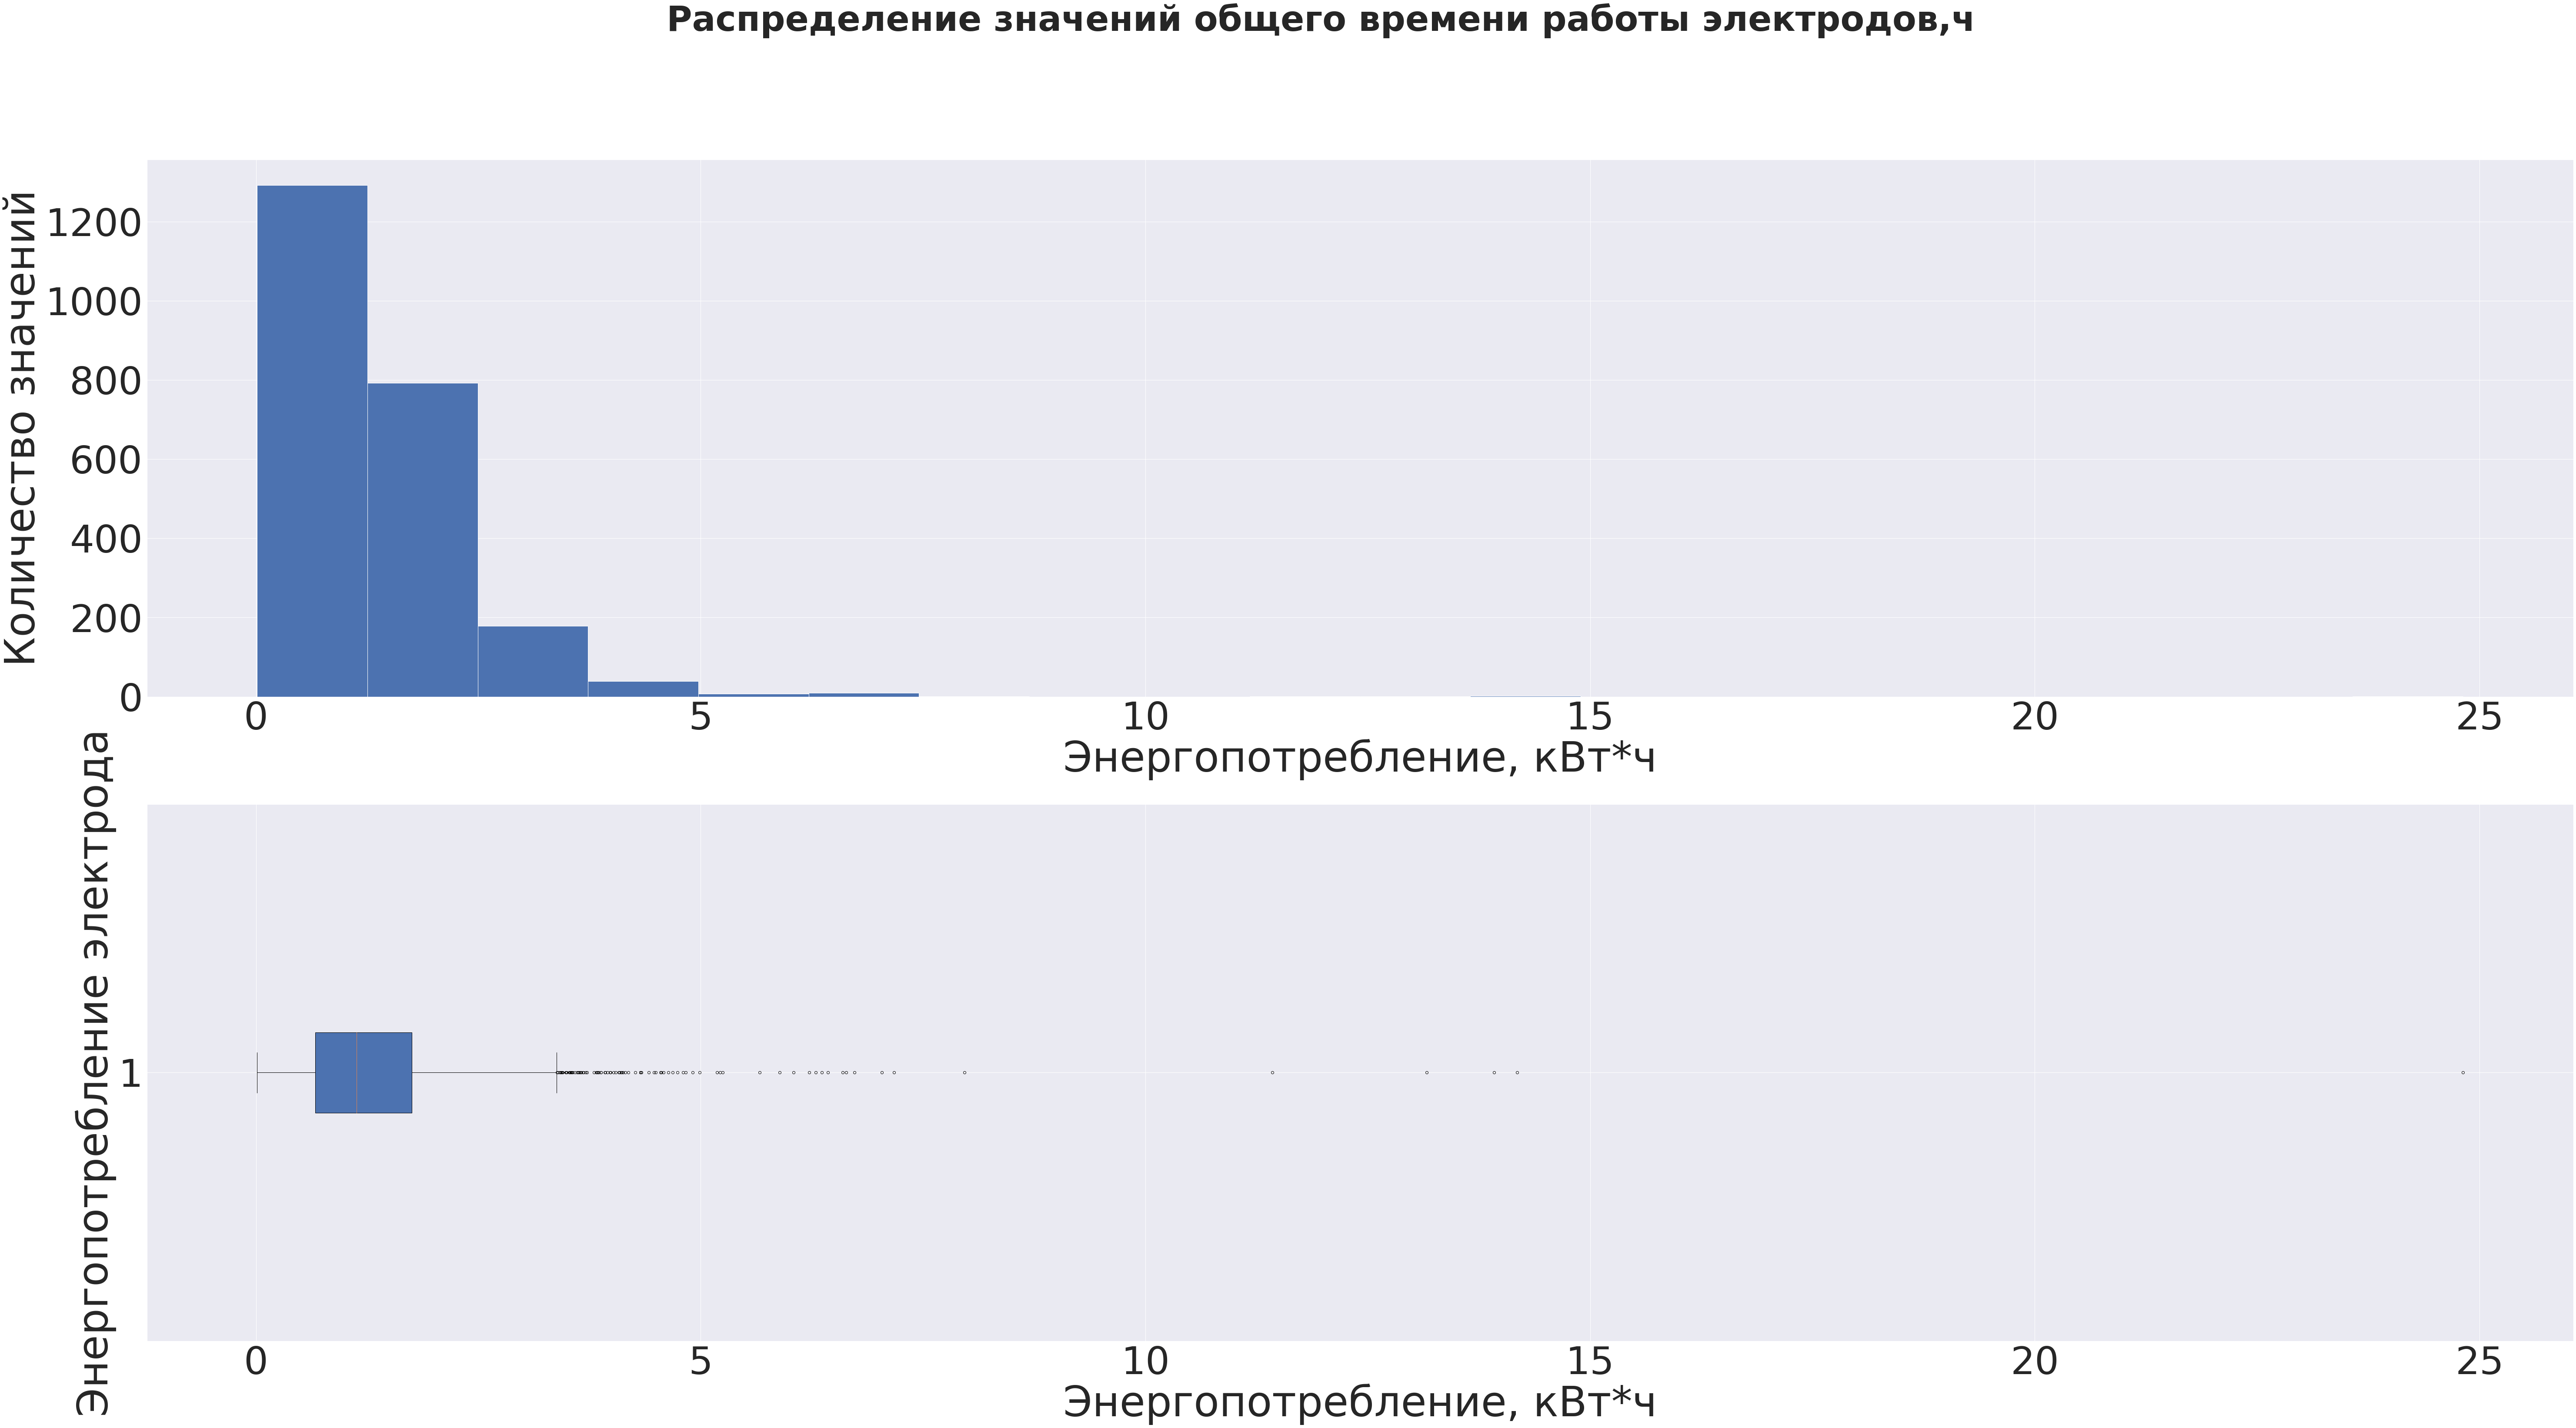

In [160]:
fig = plt.figure(figsize = (100,50))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.hist(df['Энергопотребление'],bins = 20)
ax2.boxplot(df['Энергопотребление'],vert =False,patch_artist=True)
fig.suptitle('Распределение значений общего времени работы электродов,ч', fontsize=80, fontweight='bold');
ax1.set(ylabel = 'Количество значений', xlabel = 'Энергопотребление, кВт*ч');
ax2.set(ylabel = 'Энергопотребление электрода', xlabel = 'Энергопотребление, кВт*ч');
plt.show();

Длительные циклы требуют частого нагрева,оставляем хвост справа.

## Подготовка признаков для обучения модели

Сразу откусим тестовую выборку от общего датасета и зафиксируем random_state = 280823, категориальных признаков нет, так как не планирую использовать модель линейной регрессии, то "скормлю" моделям обучающий датасет без нормализации:

In [146]:
random_state = 280823

In [147]:
df.shape

(2324, 25)

In [148]:
df.columns

Index(['Начальная Т', 'Конечная Т', 'Общее время ТП', 'Газ 1',
       'Время работы электрода', 'Энергопотребление', 'Bulk 1', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 8', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

Выделим из датасета целевой признак, в нашем случае это конечная температура расплава, "Конечная Т".

In [149]:
features = df.drop(['Конечная Т'],axis = 1)
target = df['Конечная Т']

Делим выборку на тренировочную  + тестовую,так как выборка небольшая, то оценку качества модели будем проводить с помощью метода кросс-валидации:

In [150]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=random_state)

In [151]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(1743, 24)
(581, 24)
(1743,)
(581,)


👌

## Обучение модели

### Модель случайного леса.

Для случайного леса загрузим исходные данные без нормализации, для этой модели это не так важно.

Не будем трогать сразу много параметров, начнем с основных:max_depth и n_estimators

Подберем максимальную глубину деревьев max_depth:

In [152]:
for depth in range(1,16,2):
    model_rf = RandomForestRegressor(random_state=random_state,max_depth = depth)
    MAE_rf = cross_val_score(model_rf, features_train, target_train, cv=5, scoring = 'neg_mean_absolute_error').mean()
    print("Для максимальной глубины дерева",depth,abs(MAE_rf))


Для максимальной глубины дерева 1 7.623469263452625
Для максимальной глубины дерева 3 6.734875323583859
Для максимальной глубины дерева 5 6.311899959542542
Для максимальной глубины дерева 7 6.072333776813674
Для максимальной глубины дерева 9 6.001594086400301
Для максимальной глубины дерева 11 5.991554500986344
Для максимальной глубины дерева 13 5.982672422049859
Для максимальной глубины дерева 15 6.0241027421605375


Зафиксируем значение гиперпараметра max_depth = 9 и пройдемся по гиперпараметру n_estimators:

In [153]:
for n in range(2,60,5):
    model_rf = RandomForestRegressor(max_depth = 9,n_estimators = n, random_state=random_state)
    MAE_rf = cross_val_score(model_rf, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()
    print("Для n_estimators =",n, abs(MAE_rf))

Для n_estimators = 2 6.958409697152566
Для n_estimators = 7 6.238054175032131
Для n_estimators = 12 6.180487368846533
Для n_estimators = 17 6.167000558992383
Для n_estimators = 22 6.087993011481307
Для n_estimators = 27 6.065520510464694
Для n_estimators = 32 6.028760463698065
Для n_estimators = 37 6.016971716631813
Для n_estimators = 42 6.000064084203089
Для n_estimators = 47 5.998889813769331
Для n_estimators = 52 6.005468126809914
Для n_estimators = 57 6.008839781527828


Значения метрики МАЕ одинаковые для  max_depth = 9 и n_estimators=100 (значение гиперпараметра по умолчанию) и  при n_estimators = 47 и max_depth = 9. Остановимся на первом варианте.

### Модель LGBMRegressor

In [154]:
model_lgbm = LGBMRegressor(random_state=random_state)
params_lgbm = {'max_depth':range(2,11,2)}
search_lgbm = GridSearchCV(estimator = model_lgbm,
                          param_grid = params_lgbm,
                          scoring = 'neg_mean_absolute_error',
                          cv =5)
search_lgbm.fit(features_train, target_train)
MAE_lgbm =round(abs(search_lgbm.best_score_),2)
print("Модель LGBMRegressor")
print("Лучшие параметры",search_lgbm.best_params_)
print('MAE train:', MAE_lgbm)

Модель LGBMRegressor
Лучшие параметры {'max_depth': 4}
MAE train: 5.72


Среднее значение МАЕ для модели градиентного бустинга 5.7℃,но время на обучение уходит гораздо больше чем для случайного леса.

### Выбор модели

Для тестирования выбираем модель, показавшую наименьшее значение МАЕ:
модель случайного леса с гиперпараметрами:max_depth = 9 и n_estimators=100 (значение гиперпараметра по умолчанию). У нее хорошая метрика и скорость работы на порядок выше чем у LGBMRegressor

## Тестирование модели случайного леса

In [155]:
model_rf = RandomForestRegressor(max_depth = 9,n_estimators = 100, random_state=random_state)
model_rf.fit(features_train,target_train)

RandomForestRegressor(max_depth=9, random_state=280823)

In [156]:
Y_pred = model_rf.predict(features_test)
Y_true = target_test
print("MAE:", mean_absolute_error(Y_true, Y_pred))

MAE: 6.5554179528429986


Метрика МАЕ на трейне 6.0℃, а на тесте 6.5℃. Значит модель немного переобучилась, но она хорошо справляется с поставленной задачей.

Определим важность признаков для полученной модели:

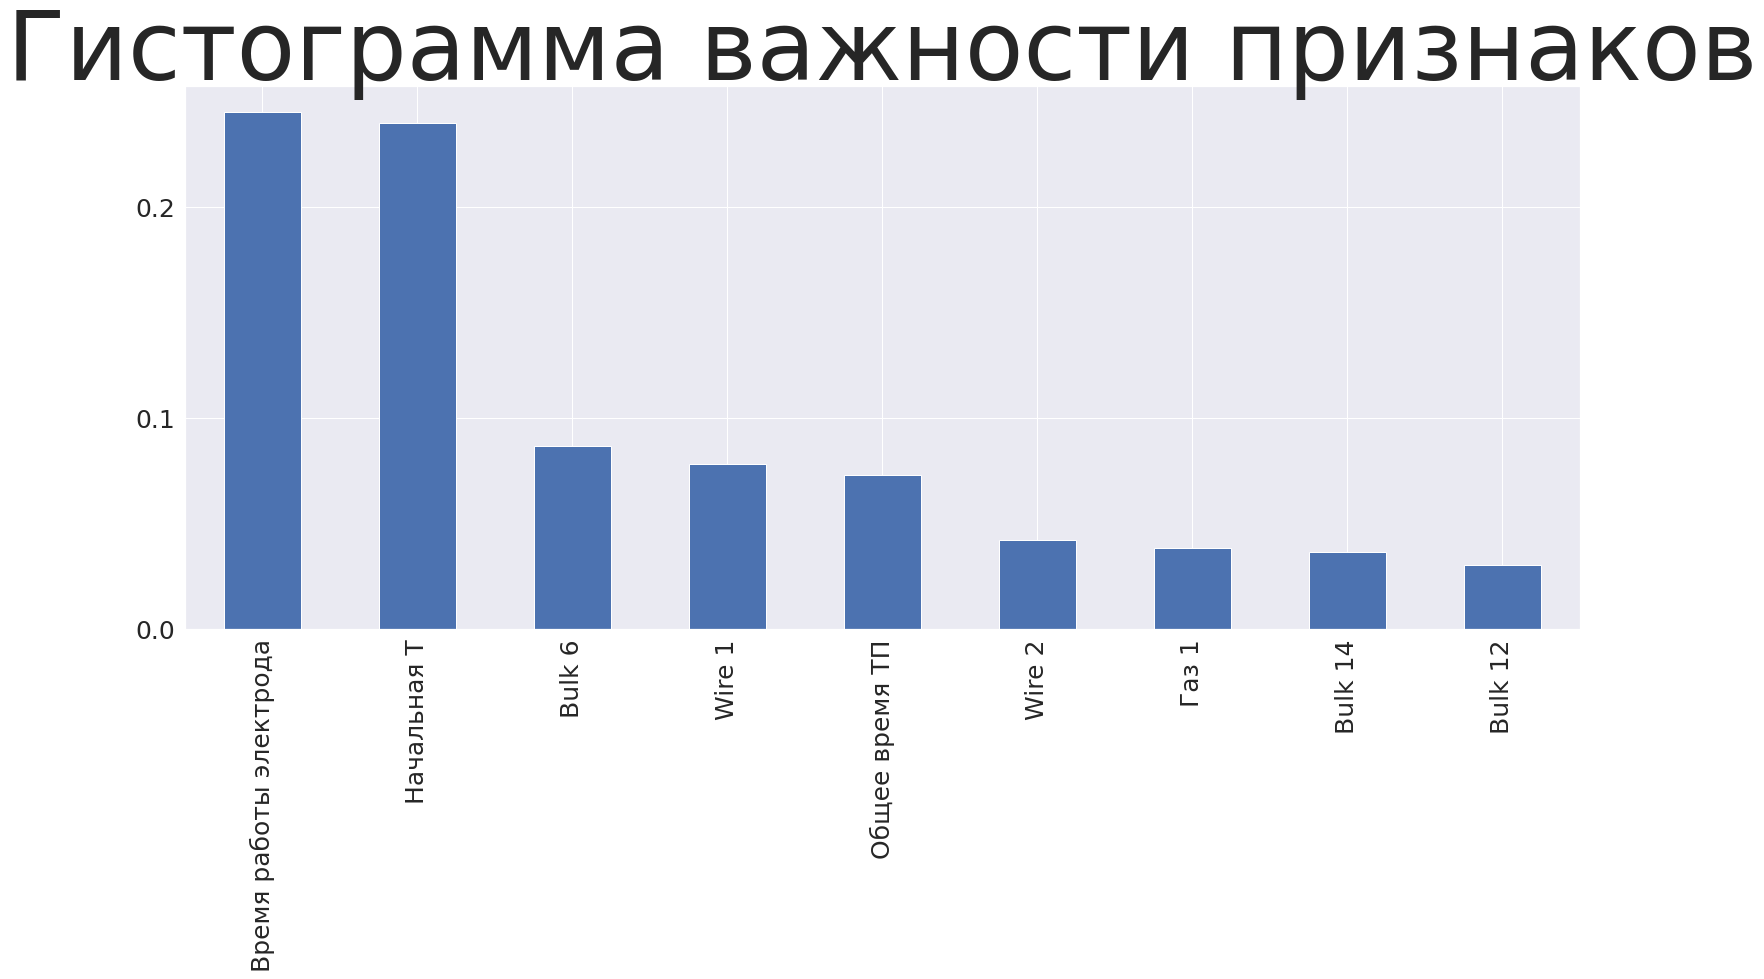

In [182]:
feature_imp = pd.Series(model_rf .feature_importances_,index=features.columns).sort_values(ascending=False)
feature_imp.iloc[0:9].plot(kind="bar",rot=90, figsize = (25,10), 
                           title='Гистограмма важности признаков', fontsize = 25);

Закономерно равнозначно весомыми оказались время работы электрода и начальная температура сплава, затем идут различные виды лигирующих добавок с различными теплоемкостями и продолжительность самого технологического процесса.

### Теперь проверим модель на адекватность:

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_pred = dummy_regr.predict(features_test)
print("MAE:", mean_absolute_error(target_test, dummy_pred))

Проверка адекватности работы модели были проведены на DummyRegressor методом предсказания по среднему значению конечной температуры. Значение метрики МАЕ составило 8,2 ℃. Конечно отрыв не большой от нашей модели, но он есть и подтверждает некую адекватность построенной модели.

## Резюме

**Резюме по разделу:**
В ходе подготовки исходных датасетов к моделированию из данных были удалены только аномальные значения, которые ни при каких условиях не могли появиться в технологическом процессе такие как отрицательная реактивная ощность электрода, температура расплавленной стали ниже 1300 ℃, значения за пределами нормального распределения оставлены нетронутыми.  

Также было обнаружено большое количество пропущенных значений в датасете, отображающем величину навески лигирующих добавок, как сыпучих, так и в виде проволоки. Так как эти пропуски были связаны с частотой применения добавок допустимо заполнить пропущенные значения нулями. Редкие добавки также не удалялись из датасетов.

В таблице, содержащей значения измерения температуры сплава содержались пропуски в значениях температуры, которые были удалены, так как данная партия содержала заведомо ложную информацию от измерительных приборов и гарантировать достоверность других измерений для этой партии мы не могли.
Дополнительно были рассчитаны такие признаки как Энергопотребление электродов, общее время работы электродов и общее время технологического процесса от первого измерения температуры до последнего.
Целевым признаком в поставленной задаче была выбрана конечная температура сплава.

При оценке линейной зависимости между признаками посредством рассчета коэффициента Пирсона, была обнаружена корреляция между некторыми типами добавок, одна из которых была в последствии удалена.

Для решения поставленной задачи регрессии были выбраны 2 модели: RandomForestRegressor и LGBMRegressor.
Напомню, что минимальная точность модели рассчитывалась по метрике MAE, которая по условиям проекта не должна превышать значение в 6,8 ℃.

Так как обучающая выборка не велика(тренировочная выборка размером 1743 на 24 и тестовая размером, обучение и рассчет метрики модели осуществлялся методом кросс-валидации.

Среди выбранных моделей для решения задач проекта была выбрана модель случайного леса, несмотря на чуть более высокую точность модели LGBMRegressor. Причина такого решения- скорость рассчетов. Случайный лес считает на порядок быстрее градиентного бустинга, а разница в метрике не такая критичная.

**МАЕ на обучающей выборке:**
  1. RandomForestRegressor - 6,0 ℃  
  2. LGBMRegressor         - 5,7 ℃ 
  
**МАЕ на тестовой выборке:**
  1. RandomForestRegressor - 6,5 ℃  

Модель немного переобучилась, но не критично.

Проверка адекватности работы модели были проведены на DummyRegressor методом предсказания по среднему значению конечной температуры. Значение метрики МАЕ составило 8,2 ℃. Конечно отрыв не большой от нашей модели, но он есть и подтверждает некую адекватность построенной модели.
 
Кроме того была проведена оценка важности признаков для выбранной модели RandomForestRegressor (с гиперпараметрами max_depth = 9,n_estimators = 100): закономерно  равнозначно весомыми оказались время работы электрода и начальная температура сплава и затем идут различные виды лигирующих добавок с различными теплоемкостями и продолжительность самого технологического процесса.

Таким образом нам удалось достичь поставленной цели в МАЕ<= 6,8 ℃



 ## Отчет по решению

### Сравнение решения и плана:
В общем и целом намеченный план был реализован, но не была проведена нормализация признаков, так как решено было не использовать в проекте модель линейной регрессии.


### Описание трудностей проекта:
Исходные данные в разных датафреймах были не синхронизированы по времени, поэтому использовать время и дату можно было в ограниченных рассчетах (восстановить хронологию технологического процесса по времени не получилось);
Есть партии, у которых режимы обработки сильно отличаются от основной массы значений, по этой причине не очень понятно выброс ли это (отклонение в процессе) или просто изготовление редкого сплава, возможно если сплавы сильно отличаются, их стоило разделить на отдельные страты;

### Ключевые шаги решения:

1.  очистка от аномалий, создание новых признаков на основе имеющихся, которые лучше отражают физическую сущность процесса, обработка пропусков с максимальным сохранением исходного распределения значений признака (где было возможно);
2. cинтез общего датасета по номеру партий стали, в конечную выборку вошли только те партии, которые были представлены во всех 5 датасетах (2 датасета с времеными метками для сыпучих и проволочных добавок не вошли в финальную выборку по причине неинформативности значений);
3. Удалены признаки линейно зависимые между собой;
4. Целевой признак, согласно ТЗ, конечная температура сплава;
5. Финальный датасет разделен на обучающую выборку и тестовую, оценка качества параметров модели проводилась методом кросс-валидации;
6. Для решения регрессионной задачи выбраны модели регрессии RandomForestRegressor и LGBMRegressor из библиотеки scikit-learn.
7. Произведен подбор гиперпараметров модели, на кросс-валидации производилась оценка точности предсказаний модели на метрике MAE (условие ТЗ);
8. Выбор итоговой модели производися по значению МАЕ и скорости обучения;
9. Тестирование выбранной модели RandomForestRegressor на тестовом датасете и проверка на адекватность постредством DummyRegressor из библиотеки scikit-learn по методу предсказания средним значением.
10.Проведен анализ важности признаков выбранной модели.

### Признаки, которые использовали для обучения и их обработка:
Из всех исходных данных, предоставленных заказчиком, для финальной выборки были использованиы следующие признаки:

1. Из **data_arc_new.csv** (данные об электродах):   
   **"Начало нагрева дугой"   
     "Конец нагрева дугой"   
     "Активная мощность"   
     "Реактивная мощность"**
    
перед загрузкой в финальный датафрейм эти признаки были пересчитаны в более интерпретируемый, а именно, **"Энергопотребление"** в кВт/ч по формуле:

    "Общая мощность" = "Активная мощность" + "Реактивная мощность"   
    "Время работы электрода" = "Конец нагрева дугой" - "Начало нагрева дугой" ( в часах)   
    "Энергопотребление" = "Общая мощность" * "Время работы электрода" (в кВт*ч)   
    
для каждой партии все значения были просуммированны.
Удалена информация о партии, в которой значение реактивной мощности составило -715 кВт (как явная аномалия);

2. Из **data_bulk_new.csv** (данные о подаче сыпучих материалов (дм3)):   
в датасете перечислены навески и типы добавок, которые использовались при изготовлении тех или иных партий стали

    "Bulk 1"   
    "Bulk 2"    
    ...      
    "Bulk 15" 
    
всего 15 различных типов, некоторые применялись часто, некоторые по 1 разу. Датасет содержал много пропущенных значений, когда добавка не использовалась в изготовлении партии. Пропуски были заполнены нулями.

3. Из **data_gas_new.csv** ( данные о продувке сплава газом (м3)):    
датасет содержит информацию об объеме инертного газа, пропущенного через расплав для перемешивания и улучшения массообмена.

    "Газ 1" 
Аномальных значений нет. Пропущенных значений нет.Все значения сохранены.

4. Из **data_temp_new.csv** (результаты измерения температуры (℃)):   
датасет содержит информацию об изменении температуры сплава в течение технлогического цикла, первое значение температуры измерялось в начале процесса, последнее- в конце, после всех обработок, также присутствуют промежуточные значения измерений температуры.

Для финального датасета были отобраны только первое и последнее измерения температуры для каждой партии:   

    "Нач_время_замера"    
    "Начальная Т"  
    "Кон_время_зам"   
    "Конечная Т" 

затем из этого датасета были удалены партии, в которых были пропущены измерения первой и последней температуры и/или значения температуры были ниже температуры плавления стали, 1300 С (аномальные значения).Промежуточные измерения не использовались при моделировании процесса.

Затем дополнительно был создан признак   

    "Продолжительность ТП"
    
по формуле:  

    "Продолжительность ТП" = "Время замера"(начальной Т) - "Время замера"(конечной Т) (значение приведены к часам) 

Это не точная продолжительность технологического процесса, но близкая к ней величина. Признаки "Нач_время_замера" и "Кон_время_зам" были удалены из конечного датасета, так как косвенно содержатся в признаке "Продолжительность ТП".

5. Из **data_wire_new.csv** (данные о проволочных материалах (дм3)):     

Датафрейм содержит информацию об объеме и кратности введения различных видов проволочных добавок для стали. Всего представлено 9 различных видов.    

    "Wire 1"   
    "Wire 2"   
    ...
    "Wire 9"   
    
Различные добавки в датасете имеют разную практику и частоту применения, есть редкие с однократным использованием, есть распространенные, аномальных значений в датасете нет. Пропуски значений, вызванные отсутствием некоторых видов добавок в рецептах определенных сплавов, заменены нулями( это значит, что при ихготовлении этой партии данная добавка не применялась).


6. Данные по времени внесения сыпучих и проволочных легирующих добавок из датасета **data_bulk_time_new.csv** (данные о подаче сыпучих материалов(время, дата)) и датасета **data_wire_time_new.csv** (данные о проволочных материалах (время,дата)) не использовались по причине рассинхронизации данных среди датасетов.

7. Итоговый датафрейм:

Конкатенация датафреймов осуществлялась по номеру партии "key", в итоговый датафрейм попали 2324 партии, информацию о которых содержали все объединяемые датафреймы.

После формирования итогового датасета, был проведен анализ признаков на линейную зависимость, обнаруженные корреляции были устранены путем удаления одного из двух зависимых признаков. В проекте это были: 'Bulk 2', 'Bulk 7','Bulk 9', 'Wire 4','Wire 5'.

**Итоговый датафрейм** содержит информацию о  2324 партиях стали, описываемых 25 различными признаками:

In [ ]:
df.info()

**Целевой признак:** 'Конечная Т'    
**Процент тестовой выборки:** 25% от общего датасета

### Описание модели

**Название модели:**             RandomForestRegressor    

**Библиотека:**                 scikit-learn   
        
**Тип модели:**                регрессионная модель   

**Подобранные гиперпараметры:** max_depth = 9,остальные значения настройки "по -умолчанию"      
                              random_state = 280823
                              
**Методика обучения и    
оценки качества модели:**       метод кросс-валидации k-Fold = 5, метрика МАЕ (условие проекта)
                              

### Итоговая метрика

**МАЕ на тестовой выборке:** 6.5℃     
**МАЕ по условиям проекта:** <= 6.8℃ на тестовой выборке

### Рекомендации по улучшению решения:

1. Синхронизировать время и дату на всех устройствах, снимающих параметры технологического процесса, что позволит выявить более точные взаимосвязи между различными стадиями процесса;
2. Так как на время и интенсивность нагрева влияют теплоемкости добавок, можно добавить датасет с этими значениями.
3. В описании технологии было сказано об автоматическом отборе пробы сплава на анализ. Имея данные о составе пробы на различных этапах технологического процесса, можно попробовать оптимизировать время и количество вносимых добавок. 
4. При анализе  датасета появилось предположение, что обрабатываемые марки стали отличаются между собой лигирующими добавками. Возможно стоит разделить сталь на марки, которые ощутимо отличаются по своим физико-химическим свойствам и моделировать процессы внутри одной марки или близких марок стали.
5. Так как размер печь-ковша достаточно большой, а выравнивание температуры в объеме происходит не так быстро, стоит дооснастить печь дополнительными датчиками измерения температуры в различных точках расплава, чтобы иметь более полное представление о средней температуре расплава.